# (17.0) Описание решаемой задачи

На основании разработанного алгоритма и определенной дельты осуществить расчет цепочек для всех найденных айсбергов

# (17.1) Установка всех необходимых пакетов¶

In [526]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

# (17.2) Определение функций¶

In [3]:
# перевод времени в формат datetime
def ReverseToDateTime(t):
    format = '%Y%m%d%H%M%S%f'
    time_str = dt.datetime.strptime(t,format)
    return time_str

# восстановление стакана заявок и расчет основных метрик
def GlassBuild(for_lob):
    
    #формируем очередь заявок
    
    # устанавливаем маску лимитных заявок заявках (True - лимитная заявка)
    no_mkt_orders = for_lob['PRICE']!=0
    # таблица выставленных заявок
    plc_orders = for_lob[['ORDERNO','BUYSELL','PRICE','VOLUME']][(for_lob ['ACTION']==1) & no_mkt_orders]
    # таблица отмененных заявок
    wdr_orders = for_lob[['ORDERNO','VOLUME']][(for_lob ['ACTION'] == 0) & no_mkt_orders]
    # таблица исполненных заявок
    trd_orders = for_lob [['ORDERNO','VOLUME']][(for_lob['ACTION']==2) & no_mkt_orders]
    trd_orders = trd_orders.groupby(['ORDERNO']).sum()
    trd_orders['ORDERNO'] = trd_orders.index
    trd_orders.index=range(trd_orders.shape[0])
    # собираем все типы заявок в один датафрейм - очередь заявок
    lob_almost = pd.merge(plc_orders,wdr_orders, on='ORDERNO',how='left',suffixes=('_plc','_wdr'))
    lob_almost = pd.merge(lob_almost,trd_orders, on='ORDERNO', how='left')
    lob_almost = lob_almost.rename(columns={'VOLUME':'VOLUME_trd'})
    lob_almost = lob_almost.fillna(0)
    lob_almost['TOTAL_VOL'] = lob_almost['VOLUME_plc'] - lob_almost['VOLUME_wdr'] - lob_almost['VOLUME_trd']
    # удаляем из очереди заявок заявки с нулевым или отрицательным объемом
    lob_almost = lob_almost[['ORDERNO','BUYSELL','PRICE','VOLUME_plc','VOLUME_wdr','VOLUME_trd','TOTAL_VOL']][(lob_almost['TOTAL_VOL']>0)]
    
    # строим стакан
    
    lob = lob_almost.pivot_table(index = "PRICE", columns = "BUYSELL", values = "TOTAL_VOL", aggfunc = 'sum')
    lob.sort_index(axis = 0, inplace = True, ascending = False)
    lob = lob.fillna(0)
    
    # считаем метрики ликвидности
    
    # расчет лучшей цены на покупку
    bid_price = lob[lob['B'] > 0].index[0]
    # расчет объема на уровне лучшей цены на покупку
    bid_volume = lob['B'][bid_price]
    # расчет общего объема на стороне покупки
    bid_depth = lob['B'].sum()
    # расчет объема на уровне 10 лучших цен на стороне покупки
    b_10 = lob[lob['B'] > 0].index[0:10]
    volume_b_10 = 0
    for i in b_10:
        volume_b_10 = volume_b_10 + lob['B'][i]
    # расчет лучшей цены на продажу
    ask_price = lob[lob['S'] > 0].index[-1]
    # расчет объема на уровне лучшей цены на продажу
    ask_volume = lob['S'][ask_price]
    # расчет общего объема на стороне продажи
    ask_depth = lob['S'].sum()
    # расчет объема на уровне 10 лучших цен на стороне продажи
    s_10 = lob[lob['S'] > 0].index[-10:]
    volume_s_10 = 0
    for i in s_10:
        volume_s_10 = volume_s_10 + lob['S'][i]
    
    liquidity = [bid_price, bid_volume, bid_depth, volume_b_10, ask_price, ask_volume, ask_depth, volume_s_10]
     
    return(liquidity)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки перед айсбергом
def ChainPairPrev(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        prev_orderno = list_of_orderno[i+1]
        cur_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        cur_time_place = orders_instr.loc[cur_time_place_1,'TIME']
        prev_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == prev_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        prev_time_trd = orders_instr.loc[prev_time_trd_1,'TIME']
    
        if (cur_time_place >= prev_time_trd) and ((cur_time_place - prev_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, prev_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# проверка, что время выставления каждой следующей заявки в цепочке больше времени исполнения предыдущей, если нет, то такая пара исключается из цепочки
# используется при формировании цепочки после айсберга
def ChainPairSuc(list_of_orderno):
    
    list_of_pairs = []
    
    for i in range(len(list_of_orderno)-1):
    
        cur_orderno = list_of_orderno[i]
        suc_orderno = list_of_orderno[i+1]
        cur_time_trd_1 = orders_instr.index[(orders_instr.ORDERNO == cur_orderno)&(orders_instr.ACTION == 2)].to_list()[-1]
        cur_time_trd = orders_instr.loc[cur_time_trd_1,'TIME']
        suc_time_place_1 = orders_instr.index[(orders_instr.ORDERNO == suc_orderno)&(orders_instr.ACTION == 1)].to_list()[0]
        suc_time_place = orders_instr.loc[suc_time_place_1,'TIME']
    
        if (suc_time_place >= cur_time_trd) and ((suc_time_place - cur_time_trd) <= delta):

            list_of_pairs.append([cur_orderno, suc_orderno])
            
        else:
            
            break
    
    list_of_orderno = [orderno]
    
    if len(list_of_pairs) != 0:

        for i in range(len(list_of_pairs)):
    
            list_of_orderno.append(list_of_pairs[i][1])
       
    return(list_of_orderno)

# (17.3) Список всех используемых датафреймов

In [4]:
# orders - ордерлог на заданную дату
# iceberg_all - список всех найденных айсбергов
# orders_instr - ордерлог по инструменту
# ice_instr - список айсбергов по одному инструменту за один день
# chains_results - список всех orderno, которые были включены в цепочку с указанием цепочки, в которую они были включены
# all_day_chain - список всех цепочек с указанием их метрик

# (17.4) Определение входных параметров

In [391]:
# создаем список из всех названий файлов с данными (из них в дальнейшем можно извлечь дату)
orderlogs = ['OrderLog20190304.txt',
             'OrderLog20190305.txt',
             'OrderLog20190306.txt',
             'OrderLog20190307.txt',
             'OrderLog20190311.txt',
             'OrderLog20190312.txt',
             'OrderLog20190313.txt',
             'OrderLog20190314.txt',
             'OrderLog20190315.txt',
             'OrderLog20190318.txt',
             'OrderLog20190319.txt',
             'OrderLog20190320.txt',
             'OrderLog20190321.txt',
             'OrderLog20190322.txt',
             'OrderLog20190325.txt',
             'OrderLog20190326.txt',
             'OrderLog20190327.txt',
             'OrderLog20190328.txt',
             'OrderLog20190329.txt'
            ]

In [347]:
# создаем список из инструментов
tickers = ['GAZP',
           'SBER',
           'GMKN',
           'LKOH',
           'MTSS',
           'MGNT',
           'TATN',
           'NVTK',
           'YNDX',
           'ROSN',
           'FIVE',
           'VTBR',
           'SNGS',
           'CHMF',
           'ALRS'
          ]

In [292]:
d = orderlogs[15] 
date = int(d[8:16]) #20190304
ticker = tickers[8] #YNDX
delta = dt.timedelta(microseconds=10000)

# (17.5) Чтение данных

In [293]:
%%time
# преобразуем time в формат datetime
# orders - ордерлог за день
# instr_orders - ордерлог на заданную дату по выбранному инструменту на момет времени t
orders = pd.read_csv(d, header = 0)
orders['together_time'] = str(date)+orders['TIME'].apply(str)
orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
del orders['together_time']

CPU times: user 7min 29s, sys: 10.3 s, total: 7min 39s
Wall time: 8min 39s


In [12]:
# читаем список выявленных айсберг-заявок + преобразуем время в формат datetime
# iceberg_all - список всех найденных айсбергов
# ice_instr - список айсбергов по одному инструменту за один день
iceberg_all = pd.read_csv('iceberg.csv', header = 0)
iceberg_all['together_time'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME'].apply(str)
iceberg_all['together_time_identified'] = iceberg_all['DATE'].apply(str)+iceberg_all['TIME_IDENT'].apply(str)
iceberg_all['TIME'] = [ReverseToDateTime(iceberg_all.together_time[i]) for i in range (len(iceberg_all.together_time))]
iceberg_all['TIME_IDENT'] = [ReverseToDateTime(iceberg_all.together_time_identified[i]) for i in range (len(iceberg_all.together_time_identified))]
iceberg_all['DELTA'] = iceberg_all['TIME_IDENT'] - iceberg_all['TIME']
del iceberg_all['together_time']
del iceberg_all['together_time_identified']

# (17.6) Расчет цепочек для одного инструмента внутри одного дня

In [80]:
orders_instr = orders[orders.SECCODE == ticker].reset_index()
orders_instr

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,2297,2298,YNDX,S,2019-03-04 10:00:00.000000,2298,1,2315.0,50,NaN,NaN
1,2957,2958,YNDX,S,2019-03-04 10:00:00.000000,2958,1,2300.0,50,NaN,NaN
2,3637,3638,YNDX,S,2019-03-04 10:00:00.000000,3638,1,2298.8,18,NaN,NaN
3,4577,4578,YNDX,S,2019-03-04 10:00:00.000000,4578,1,2449.8,1,NaN,NaN
4,4600,4601,YNDX,S,2019-03-04 10:00:00.000000,4601,1,2399.8,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
129855,5424251,5424252,YNDX,S,2019-03-04 18:44:44.459528,2357504,0,2317.4,5,NaN,NaN
129856,5424260,5424261,YNDX,B,2019-03-04 18:44:48.444374,2565342,0,2231.0,92,NaN,NaN
129857,5424328,5424329,YNDX,B,2019-03-04 18:44:59.238014,2196857,0,2297.6,29,NaN,NaN
129858,5424342,5424343,YNDX,B,2019-03-04 18:44:59.243531,2192515,0,2296.4,25,NaN,NaN


In [127]:
ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]
ice_instr 

,index,BUYSELL,DATE,ICEBERG,ORDERNO,PRICE,SECCODE,TIME,TIME_IDENT,VOLUME,VOLUME_INI,DELTA,CHAIN_ID
4573,0,B,20190305,1,87698,2285.2,YNDX,2019-03-05 10:01:10.287006,2019-03-05 10:18:40.750123,-400,100,00:17:30.463117,0
4574,1,B,20190305,1,99596,2275.2,YNDX,2019-03-05 10:01:47.844531,2019-03-05 11:50:19.645979,-400,100,01:48:31.801448,0
4575,2,B,20190305,1,124637,2290.2,YNDX,2019-03-05 10:03:25.996026,2019-03-05 10:03:25.996026,-5,100,00:00:00,0
4576,3,B,20190305,1,124639,2290.2,YNDX,2019-03-05 10:03:25.996061,2019-03-05 10:03:25.996096,-90,95,00:00:00.000035,0
4577,4,B,20190305,1,124642,2290.2,YNDX,2019-03-05 10:03:25.996352,2019-03-05 10:03:25.996651,-149,10,00:00:00.000299,0
4578,5,B,20190305,1,873624,2280.2,YNDX,2019-03-05 11:40:46.336752,2019-03-05 11:49:04.716842,-400,100,00:08:18.380090,0
4579,6,B,20190305,1,899500,2281.6,YNDX,2019-03-05 11:44:02.797919,2019-03-05 11:49:04.716842,-400,100,00:05:01.918923,0
4580,7,B,20190305,1,955982,2277.2,YNDX,2019-03-05 11:49:56.378447,2019-03-05 11:49:56.378447,-400,100,00:00:00,0
4581,8,B,20190305,1,966933,2276.0,YNDX,2019-03-05 11:51:52.892656,2019-03-05 11:51:52.892656,-900,100,00:00:00,0
4582,9,B,20190305,1,1079738,2275.0,YNDX,2019-03-05 12:08:54.637858,2019-03-05 12:16:35.052049,-74,100,00:07:40.414191,0


In [83]:
%%time

chains = []
ice_instr['CHAIN_ID'] = 0

for i in range(len(ice_instr)):
    
    id = ice_instr.index[i]
    print(id, ice_instr.loc[id, 'CHAIN_ID'])
    
    # проверяем
    if ice_instr.loc[id, 'CHAIN_ID'] == 0:
    
        buysell = iceberg_all.loc[id][1]
        date = iceberg_all.loc[id][2]
        orderno = iceberg_all.loc[id][4]
        price = iceberg_all.loc[id][5]
        ticker = iceberg_all.loc[id][6]
        time_place = iceberg_all.loc[id][7]
        time_ident = iceberg_all.loc[id][8]
        volume_ini = iceberg_all.loc[id][10]

        left_border = ReverseToDateTime('20190304100000000000')
        right_border = ReverseToDateTime('20190304184500000000')

        # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
        # test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
        test = orders_instr[((orders_instr.BUYSELL == buysell) & 
                     (orders_instr.PRICE == price) & 
                     (orders_instr.TIME >= left_border)& 
                     (orders_instr.TIME <= time_ident)&
                     (orders_instr.ORDERNO < orderno)&
                     (orders_instr.ACTION == 2)     
                    )]['ORDERNO'].unique().tolist()

        # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
        # test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
        test1 = []

        for i in test:

            trade_orderno = i
            order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

            if order_volume == volume_ini:

                test1.append(i)

        # дописываем номер айсберг заявки в найденную цепочку
        test1.append(orderno)
        # разворачиваем список заявок от самой новой до самой старой
        test1 = test1[::-1]

        # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
        chain_prev = ChainPairPrev(test1)

        right_border = ReverseToDateTime('20190304184500000000')

        # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
        # train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
        train = orders_instr[((orders_instr.BUYSELL == buysell) & 
                     (orders_instr.PRICE == price) & 
                     (orders_instr.TIME >= time_ident)& 
                     (orders_instr.TIME <= right_border)&
                     (orders_instr.ORDERNO > orderno)&
                     (orders_instr.ACTION == 1)     
                    )]['ORDERNO'].unique().tolist()

        # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга + проверяем, что по всем найденным заявкам была сделка
        # train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
        train1 = [orderno]

        for i in train:

            trade_orderno = i
            order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
            trade_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 2)]['VOLUME'].sum()

            if (order_volume == volume_ini) and (order_volume <= trade_volume):

                train1.append(i)

        # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
        chain_suc = ChainPairSuc(train1)
        chain_suc

        # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
        chain_suc = ChainPairSuc(train1)

        chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]

        #print(id, len(chain))

        chains.append([chain])

        # определяем индекс всех айсбергов, которые вошли в цепочку и меняем их chain_id
        ices = ice_instr.index[ice_instr['ORDERNO'].isin(chain)].to_list()

        for k in ices:

            ice_instr.loc[k, 'CHAIN_ID'] = chain[0]  

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1499 0
1500 0
1501 0
1502 0
1503 0
1504 0
1505 0
1506 0
1507 0
1508 0
1509 0
1510 0
1511 0
1512 0
1513 0
1514 0
1515 0
1516 0
1517 0
1518 0
1519 0
1520 0
1521 0
1522 0
1523 0
1524 0
1525 0
1526 0
1527 0
1528 0
1529 0
1530 0
1531 0
1532 0
1533 0
1534 0
1535 0
1536 0
1537 0
1538 0
1539 0
1540 0
1541 0
1542 0
1543 0
1544 0
1545 0
CPU times: user 37 s, sys: 782 ms, total: 37.8 s
Wall time: 45.6 s


# (17.7) Расчет цепочек для всех инструментов внутри одного дня

In [294]:
%%time
# собираем цепочки за день
chains_all = []

for m in tickers:
    
    ticker = m
    print(ticker)
    orders_instr = orders[orders.SECCODE == ticker].reset_index()
    ice_instr = iceberg_all[(iceberg_all.SECCODE == ticker) & (iceberg_all.DATE == date)]
    
    chains = []
    ice_instr['CHAIN_ID'] = 0

    for i in range(len(ice_instr)):

        id = ice_instr.index[i]

        # проверяем
        if ice_instr.loc[id, 'CHAIN_ID'] == 0:

            buysell = iceberg_all.loc[id][1]
            date = iceberg_all.loc[id][2]
            orderno = iceberg_all.loc[id][4]
            price = iceberg_all.loc[id][5]
            ticker = iceberg_all.loc[id][6]
            time_place = iceberg_all.loc[id][7]
            time_ident = iceberg_all.loc[id][8]
            volume_ini = iceberg_all.loc[id][10]

            left_border = ReverseToDateTime('20190304100000000000')
            right_border = ReverseToDateTime('20190304184500000000')

            # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
            # test - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
            test = orders_instr[((orders_instr.BUYSELL == buysell) & 
                         (orders_instr.PRICE == price) & 
                         (orders_instr.TIME >= left_border)& 
                         (orders_instr.TIME <= time_ident)&
                         (orders_instr.ORDERNO < orderno)&
                         (orders_instr.ACTION == 2)     
                        )]['ORDERNO'].unique().tolist()

            # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга
            # test1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
            test1 = []

            for i in test:

                trade_orderno = i
                order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]

                if order_volume == volume_ini:

                    test1.append(i)

            # дописываем номер айсберг заявки в найденную цепочку
            test1.append(orderno)
            # разворачиваем список заявок от самой новой до самой старой
            test1 = test1[::-1]

            # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
            chain_prev = ChainPairPrev(test1)

            right_border = ReverseToDateTime('20190304184500000000')

            # отбираем все заявки с параметрами айсберга (кроме объема), сделки по которым произошли в заданном интервале
            # train - список всех заявок с параматерами айсберга (кроме объема), сделки по которым произошли в заданном интервале
            train = orders_instr[((orders_instr.BUYSELL == buysell) & 
                         (orders_instr.PRICE == price) & 
                         (orders_instr.TIME >= time_ident)& 
                         (orders_instr.TIME <= right_border)&
                         (orders_instr.ORDERNO > orderno)&
                         (orders_instr.ACTION == 1)     
                        )]['ORDERNO'].unique().tolist()

            # проверяем, что исходный объем найденных заявок совпадает с видимой частью айсберга + проверяем, что по всем найденным заявкам была сделка
            # train1 - список всех заявок с параматерами айсберга, сделки по которым произошли в заданном интервале
            train1 = [orderno]

            for i in train:

                trade_orderno = i
                order_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 1)]['VOLUME'].values[0]
                trade_volume = orders_instr.loc[(orders_instr.ORDERNO == trade_orderno) & (orders_instr.ACTION == 2)]['VOLUME'].sum()

                if (order_volume == volume_ini) and (order_volume <= trade_volume):

                    train1.append(i)

            # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
            chain_suc = ChainPairSuc(train1)
            chain_suc

            # проверяем, что время между выставлениями заявок в цепочке меньше, чем заданная ранее дельта и создаем список из заявок, которые удовлетворяют этому условию
            chain_suc = ChainPairSuc(train1)

            chain = chain_prev[::-1] + chain_suc[1:len(chain_suc)]

            #print(id, len(chain))

            chains.append([chain])

            # определяем индекс всех айсбергов, которые вошли в цепочку и меняем их chain_id в ice_instr
            ices = ice_instr.index[(ice_instr['ORDERNO'].isin(chain)) & (ice_instr.DATE == date)].to_list()

            for k in ices:

                ice_instr.loc[k, 'CHAIN_ID'] = chain[0]
            
            # определяем индекс всех айсбергов, которые вошли в цепочку и меняем их chain_id в iceberg_all
            ices1 = iceberg_all.index[(iceberg_all['ORDERNO'].isin(chain)) & (iceberg_all.DATE == date)].to_list()
            
            for l in ices1:
                
                iceberg_all.loc[l, 'CHAIN_ID'] = chain[0]
    
    print(1)
    chains_all.append([ticker, chains])

GAZP


/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


1
SBER
1
GMKN
1
LKOH
1
MTSS
1
MGNT
1
TATN
1
NVTK
1
YNDX
1
ROSN
1
FIVE
1
VTBR
1
SNGS
1
CHMF
1
ALRS
1
CPU times: user 30min 7s, sys: 30.5 s, total: 30min 37s
Wall time: 9h 36min 11s


In [300]:
# сливаем данные по всем цепочкам в один список
chains_per_day = [chains_all_04,
                  chains_all_05,
                  chains_all_06,
                  chains_all_07,
                  chains_all_11,
                  chains_all_12,
                  chains_all_13,
                  chains_all_14,
                  chains_all_15,
                  chains_all_18,
                  chains_all_19,
                  chains_all_20,
                  chains_all_21,
                  chains_all_22,
                  chains_all_25,
                  chains_all_26,
                  chains_all_27,
                  chains_all_28,
                  chains_all_29
                 ]

In [318]:
# учимся работать с собранным списком chains_per_day
# chains_per_day - список всех цепочек за все дни
# chains_per_day[0] - список цепочек по всем инструментам за первый день
# chains_per_day[0][0][0] - инструмент цепочки (НОЛЬ НЕ МЕНЯТЬ)
# chains_per_day[0][0][1] - цепочка по инструменту (ЕДИНИЦУ НЕ МЕНЯТЬ)
# chains_per_day[0][0][1][4][0] - пятая цепочка по инструменту
# chains_per_day[0][0][1][4][0][0] - первый элемент пятой цепочки по инструменту

283520

In [356]:
# собираем данные по найденным цепочкам в датафрейм и сохраняем его для возможности дальнейшей работы
dates1 = []
tickers1 = []
orders1 = []
chains1 = []

for a in range(len(orderlogs)):
    
    date = int(orderlogs[a][8:16])
    
    for b in range(len(tickers)):

        ticker = tickers[b]
        
        for c in range(len(chains_per_day[a][b][1])):
            
            chain = chains_per_day[a][b][1][c][0][0]
            
            for d in range(len(chains_per_day[a][b][1][c][0])):
                
                dates1.append(date)
                tickers1.append(ticker)
                orders1.append(chains_per_day[a][b][1][c][0][d])
                chains1.append(chain)
                
chain_results = pd.DataFrame({'DATE':pd.Series(dates1),
                  'TICKER':pd.Series(tickers1),
                  'ORDERNO':pd.Series(orders1),
                  'CHAIN_ID':pd.Series(chains1)                  
                 })

chain_results.to_csv('chain_results', index = 0)
chain_results

20190304
20190304 GAZP
20190304 GAZP 199077
20190304 GAZP 359638
20190304 GAZP 397852
20190304 GAZP 486370
20190304 GAZP 283520
20190304 GAZP 560068
20190304 GAZP 560069
20190304 GAZP 626087
20190304 GAZP 693576
20190304 GAZP 707548
20190304 GAZP 707551
20190304 GAZP 769025
20190304 GAZP 871524
20190304 GAZP 881498
20190304 GAZP 886166
20190304 GAZP 886174
20190304 GAZP 914062
20190304 GAZP 914065
20190304 GAZP 914066
20190304 GAZP 914067
20190304 GAZP 914068
20190304 GAZP 914069
20190304 GAZP 926050
20190304 GAZP 1035425
20190304 GAZP 1052785
20190304 GAZP 1087211
20190304 GAZP 1104411
20190304 GAZP 1104413
20190304 GAZP 1104416
20190304 GAZP 1106406
20190304 GAZP 1107098
20190304 GAZP 1109306
20190304 GAZP 1108892
20190304 GAZP 1110468
20190304 GAZP 1110474
20190304 GAZP 1110622
20190304 GAZP 1117143
20190304 GAZP 1117214
20190304 GAZP 1117233
20190304 GAZP 1117768
20190304 GAZP 1118096
20190304 GAZP 1118510
20190304 GAZP 1118654
20190304 GAZP 1119094
20190304 GAZP 1119112
20190304 G

20190304 SBER 659640
20190304 SBER 661327
20190304 SBER 668800
20190304 SBER 677828
20190304 SBER 678321
20190304 SBER 679103
20190304 SBER 684525
20190304 SBER 685967
20190304 SBER 691198
20190304 SBER 695265
20190304 SBER 712274
20190304 SBER 712772
20190304 SBER 724509
20190304 SBER 739114
20190304 SBER 739583
20190304 SBER 714049
20190304 SBER 745727
20190304 SBER 751062
20190304 SBER 753732
20190304 SBER 753737
20190304 SBER 753749
20190304 SBER 765706
20190304 SBER 766349
20190304 SBER 768223
20190304 SBER 772326
20190304 SBER 772944
20190304 SBER 783918
20190304 SBER 785391
20190304 SBER 785896
20190304 SBER 791651
20190304 SBER 793690
20190304 SBER 793691
20190304 SBER 793747
20190304 SBER 793822
20190304 SBER 793887
20190304 SBER 795425
20190304 SBER 797463
20190304 SBER 801571
20190304 SBER 805649
20190304 SBER 807629
20190304 SBER 807667
20190304 SBER 807937
20190304 SBER 807946
20190304 SBER 807974
20190304 SBER 807995
20190304 SBER 808004
20190304 SBER 808021
20190304 SBER

20190304 LKOH 1738308
20190304 LKOH 1738309
20190304 LKOH 1738310
20190304 LKOH 1738311
20190304 LKOH 1738323
20190304 LKOH 1763820
20190304 LKOH 1766803
20190304 LKOH 1766837
20190304 LKOH 1766854
20190304 LKOH 1766867
20190304 LKOH 1766871
20190304 LKOH 1766880
20190304 LKOH 1766891
20190304 LKOH 1766944
20190304 LKOH 1778601
20190304 LKOH 1780926
20190304 LKOH 1785166
20190304 LKOH 1785169
20190304 LKOH 1785202
20190304 LKOH 1785218
20190304 LKOH 1785228
20190304 LKOH 1786498
20190304 LKOH 1793155
20190304 LKOH 1800445
20190304 LKOH 1800952
20190304 LKOH 1800959
20190304 LKOH 1800964
20190304 LKOH 1800970
20190304 LKOH 1800975
20190304 LKOH 1800993
20190304 LKOH 1804166
20190304 LKOH 1804167
20190304 LKOH 1804168
20190304 LKOH 1806402
20190304 LKOH 1806383
20190304 LKOH 1882474
20190304 LKOH 2038320
20190304 LKOH 2038326
20190304 LKOH 2050739
20190304 LKOH 2050740
20190304 LKOH 2050741
20190304 LKOH 2075185
20190304 LKOH 2076373
20190304 LKOH 2076374
20190304 LKOH 2076375
20190304 L

20190304 ALRS 1165666
20190304 ALRS 1165667
20190304 ALRS 1165668
20190304 ALRS 1165669
20190304 ALRS 1165671
20190304 ALRS 1165672
20190304 ALRS 1165673
20190304 ALRS 1165676
20190304 ALRS 1165677
20190304 ALRS 1165678
20190304 ALRS 1199765
20190304 ALRS 1214341
20190304 ALRS 1214342
20190304 ALRS 1214343
20190304 ALRS 1214344
20190304 ALRS 1214345
20190304 ALRS 1214346
20190304 ALRS 1214347
20190304 ALRS 1214350
20190304 ALRS 1270547
20190304 ALRS 1277716
20190304 ALRS 1279418
20190304 ALRS 1279419
20190304 ALRS 1279420
20190304 ALRS 1279421
20190304 ALRS 1279422
20190304 ALRS 1279423
20190304 ALRS 1279512
20190304 ALRS 1279836
20190304 ALRS 1312482
20190304 ALRS 1324944
20190304 ALRS 1324947
20190304 ALRS 1326038
20190304 ALRS 1326675
20190304 ALRS 1326873
20190304 ALRS 1344331
20190304 ALRS 1330566
20190304 ALRS 1363954
20190304 ALRS 1372038
20190304 ALRS 1379692
20190304 ALRS 1381039
20190304 ALRS 1416732
20190304 ALRS 1425953
20190304 ALRS 1426053
20190304 ALRS 1426574
20190304 A

20190305 SBER 232586
20190305 SBER 232668
20190305 SBER 232688
20190305 SBER 232694
20190305 SBER 232668
20190305 SBER 236533
20190305 SBER 246842
20190305 SBER 246917
20190305 SBER 248694
20190305 SBER 247805
20190305 SBER 247822
20190305 SBER 250187
20190305 SBER 250187
20190305 SBER 250190
20190305 SBER 250405
20190305 SBER 250452
20190305 SBER 250481
20190305 SBER 252602
20190305 SBER 255048
20190305 SBER 255329
20190305 SBER 255436
20190305 SBER 255639
20190305 SBER 255684
20190305 SBER 255684
20190305 SBER 255763
20190305 SBER 255684
20190305 SBER 255763
20190305 SBER 255763
20190305 SBER 255763
20190305 SBER 255763
20190305 SBER 255763
20190305 SBER 255777
20190305 SBER 255777
20190305 SBER 255777
20190305 SBER 255818
20190305 SBER 255818
20190305 SBER 255835
20190305 SBER 255854
20190305 SBER 255854
20190305 SBER 255854
20190305 SBER 255854
20190305 SBER 255943
20190305 SBER 255977
20190305 SBER 256052
20190305 SBER 256178
20190305 SBER 256557
20190305 SBER 256563
20190305 SBER

20190305 SBER 1123686
20190305 SBER 1123710
20190305 SBER 1123710
20190305 SBER 1123800
20190305 SBER 1123862
20190305 SBER 1123862
20190305 SBER 1123880
20190305 SBER 1123880
20190305 SBER 1123887
20190305 SBER 1123890
20190305 SBER 1123862
20190305 SBER 1131430
20190305 SBER 1131440
20190305 SBER 1131444
20190305 SBER 1131482
20190305 SBER 1131539
20190305 SBER 1131555
20190305 SBER 1131555
20190305 SBER 1131689
20190305 SBER 1131784
20190305 SBER 1131909
20190305 SBER 1131909
20190305 SBER 1134325
20190305 SBER 1134600
20190305 SBER 1153300
20190305 SBER 1138653
20190305 SBER 1159912
20190305 SBER 1159929
20190305 SBER 1159930
20190305 SBER 1159947
20190305 SBER 1159983
20190305 SBER 1160030
20190305 SBER 1160040
20190305 SBER 1160058
20190305 SBER 1160106
20190305 SBER 1160122
20190305 SBER 1160613
20190305 SBER 1160614
20190305 SBER 1160617
20190305 SBER 1160617
20190305 SBER 1160620
20190305 SBER 1130818
20190305 SBER 1175231
20190305 SBER 1176249
20190305 SBER 1177914
20190305 S

20190305 SBER 2007890
20190305 SBER 2007817
20190305 SBER 2007924
20190305 SBER 2007938
20190305 SBER 2007817
20190305 SBER 2007817
20190305 SBER 2007817
20190305 SBER 2008040
20190305 SBER 2008053
20190305 SBER 2008059
20190305 SBER 2008068
20190305 SBER 2008070
20190305 SBER 2008072
20190305 SBER 2008079
20190305 SBER 2008085
20190305 SBER 2008089
20190305 SBER 2008091
20190305 SBER 2008099
20190305 SBER 2008091
20190305 SBER 2008085
20190305 SBER 2008091
20190305 SBER 2008122
20190305 SBER 2008135
20190305 SBER 2008146
20190305 SBER 2008148
20190305 SBER 2008152
20190305 SBER 2008152
20190305 SBER 2008152
20190305 SBER 2008152
20190305 SBER 2008152
20190305 SBER 2008168
20190305 SBER 2008135
20190305 SBER 2008135
20190305 SBER 2008207
20190305 SBER 2008234
20190305 SBER 2008236
20190305 SBER 2008241
20190305 SBER 2008241
20190305 SBER 2008253
20190305 SBER 2008259
20190305 SBER 2008261
20190305 SBER 2008273
20190305 SBER 2008283
20190305 SBER 1617731
20190305 SBER 2008406
20190305 S

20190305 MGNT 2851529
20190305 MGNT 2851557
20190305 MGNT 2851573
20190305 MGNT 2851585
20190305 MGNT 2851614
20190305 MGNT 2851634
20190305 MGNT 2851671
20190305 MGNT 2851794
20190305 MGNT 2851794
20190305 MGNT 2851866
20190305 MGNT 2851866
20190305 MGNT 2851866
20190305 MGNT 2851912
20190305 MGNT 2876830
20190305 MGNT 2978488
20190305 MGNT 2978490
20190305 MGNT 2978834
20190305 MGNT 2978834
20190305 MGNT 2978834
20190305 MGNT 2978834
20190305 MGNT 2978834
20190305 MGNT 3050714
20190305 MGNT 3050715
20190305 MGNT 3050716
20190305 MGNT 3050714
20190305 MGNT 3054046
20190305 MGNT 3057218
20190305 MGNT 3057542
20190305 MGNT 3057843
20190305 MGNT 3058116
20190305 MGNT 3058586
20190305 MGNT 3058779
20190305 TATN
20190305 TATN 253655
20190305 TATN 253656
20190305 TATN 253657
20190305 TATN 333363
20190305 TATN 349514
20190305 TATN 1098395
20190305 TATN 1098414
20190305 TATN 1098414
20190305 NVTK
20190305 NVTK 1708758
20190305 NVTK 1708759
20190305 NVTK 1708760
20190305 NVTK 1712807
20190305 

20190305 ALRS 2071252
20190305 ALRS 2073484
20190305 ALRS 2074351
20190305 ALRS 2074893
20190305 ALRS 2075408
20190305 ALRS 2075935
20190305 ALRS 2077744
20190305 ALRS 2081036
20190305 ALRS 2081086
20190305 ALRS 2081379
20190305 ALRS 2081792
20190305 ALRS 2082205
20190305 ALRS 2086713
20190305 ALRS 2085848
20190305 ALRS 2106845
20190305 ALRS 2109635
20190305 ALRS 2121254
20190305 ALRS 2145431
20190305 ALRS 2152972
20190305 ALRS 2224344
20190305 ALRS 2242796
20190305 ALRS 2244194
20190305 ALRS 2244197
20190305 ALRS 2244199
20190305 ALRS 2244201
20190305 ALRS 2250082
20190305 ALRS 2260152
20190305 ALRS 2284748
20190305 ALRS 2292065
20190305 ALRS 2333550
20190305 ALRS 2346423
20190305 ALRS 2346425
20190305 ALRS 2346427
20190305 ALRS 2346432
20190305 ALRS 2346436
20190305 ALRS 2333550
20190305 ALRS 2346453
20190305 ALRS 2346484
20190305 ALRS 2346487
20190305 ALRS 2346570
20190305 ALRS 2349872
20190305 ALRS 2403003
20190305 ALRS 2419666
20190305 ALRS 2432400
20190305 ALRS 2466396
20190305 A

20190306 SBER 187093
20190306 SBER 187077
20190306 SBER 187099
20190306 SBER 187077
20190306 SBER 187099
20190306 SBER 187137
20190306 SBER 187200
20190306 SBER 187200
20190306 SBER 187200
20190306 SBER 187209
20190306 SBER 187219
20190306 SBER 187340
20190306 SBER 187360
20190306 SBER 187361
20190306 SBER 127090
20190306 SBER 188223
20190306 SBER 188248
20190306 SBER 188359
20190306 SBER 188554
20190306 SBER 188654
20190306 SBER 188655
20190306 SBER 188692
20190306 SBER 188762
20190306 SBER 188839
20190306 SBER 188841
20190306 SBER 188842
20190306 SBER 188847
20190306 SBER 188849
20190306 SBER 188851
20190306 SBER 188852
20190306 SBER 188855
20190306 SBER 188847
20190306 SBER 188849
20190306 SBER 188851
20190306 SBER 188852
20190306 SBER 188855
20190306 SBER 188847
20190306 SBER 188849
20190306 SBER 188851
20190306 SBER 188933
20190306 SBER 188946
20190306 SBER 188948
20190306 SBER 188951
20190306 SBER 188953
20190306 SBER 188954
20190306 SBER 189021
20190306 SBER 189033
20190306 SBER

20190306 SBER 614070
20190306 SBER 614075
20190306 SBER 614075
20190306 SBER 614083
20190306 SBER 591251
20190306 SBER 614345
20190306 SBER 614353
20190306 SBER 591251
20190306 SBER 492684
20190306 SBER 615065
20190306 SBER 492684
20190306 SBER 615093
20190306 SBER 615117
20190306 SBER 615065
20190306 SBER 615117
20190306 SBER 615065
20190306 SBER 615260
20190306 SBER 615117
20190306 SBER 615260
20190306 SBER 615065
20190306 SBER 615117
20190306 SBER 615238
20190306 SBER 615277
20190306 SBER 615065
20190306 SBER 615117
20190306 SBER 615117
20190306 SBER 615065
20190306 SBER 615117
20190306 SBER 615117
20190306 SBER 615065
20190306 SBER 615117
20190306 SBER 615065
20190306 SBER 615065
20190306 SBER 615117
20190306 SBER 616095
20190306 SBER 616096
20190306 SBER 616141
20190306 SBER 616146
20190306 SBER 616316
20190306 SBER 618541
20190306 SBER 620709
20190306 SBER 620714
20190306 SBER 620733
20190306 SBER 620775
20190306 SBER 620959
20190306 SBER 621827
20190306 SBER 621880
20190306 SBER

20190306 SBER 1349756
20190306 SBER 1349764
20190306 SBER 1349756
20190306 SBER 1349771
20190306 SBER 1349773
20190306 SBER 1349779
20190306 SBER 1349821
20190306 SBER 1349823
20190306 SBER 1349834
20190306 SBER 1349879
20190306 SBER 1349924
20190306 SBER 1349972
20190306 SBER 1349972
20190306 SBER 1350017
20190306 SBER 1350025
20190306 SBER 1350027
20190306 SBER 1350043
20190306 SBER 1350043
20190306 SBER 1350087
20190306 SBER 1350088
20190306 SBER 1350092
20190306 SBER 1352071
20190306 SBER 1356040
20190306 SBER 1356088
20190306 SBER 1357379
20190306 SBER 1357390
20190306 SBER 1357493
20190306 SBER 1357732
20190306 SBER 1357745
20190306 SBER 1358045
20190306 SBER 1358572
20190306 SBER 1359978
20190306 SBER 1360188
20190306 SBER 1362181
20190306 SBER 1362182
20190306 SBER 1362183
20190306 SBER 1362181
20190306 SBER 1362186
20190306 SBER 1362187
20190306 SBER 1362188
20190306 SBER 1362189
20190306 SBER 1362181
20190306 SBER 1362217
20190306 SBER 1362229
20190306 SBER 1362344
20190306 S

20190306 SBER 2062885
20190306 SBER 2062885
20190306 SBER 2062895
20190306 SBER 2062898
20190306 SBER 2062898
20190306 SBER 2062904
20190306 SBER 2062907
20190306 SBER 2063370
20190306 SBER 2063386
20190306 SBER 2063496
20190306 SBER 1996698
20190306 SBER 2071877
20190306 SBER 2071938
20190306 SBER 2071938
20190306 SBER 2072297
20190306 SBER 2074958
20190306 SBER 2075071
20190306 SBER 2075225
20190306 SBER 2075335
20190306 SBER 2089821
20190306 SBER 2089821
20190306 SBER 2089855
20190306 SBER 2089858
20190306 SBER 2089858
20190306 SBER 2089858
20190306 SBER 2089876
20190306 SBER 2089882
20190306 SBER 2089889
20190306 SBER 2089858
20190306 SBER 2089858
20190306 SBER 2089914
20190306 SBER 2089914
20190306 SBER 2089858
20190306 SBER 2089928
20190306 SBER 2089942
20190306 SBER 2089954
20190306 SBER 2089971
20190306 SBER 2089973
20190306 SBER 2089977
20190306 SBER 2089979
20190306 SBER 2089990
20190306 SBER 2090020
20190306 SBER 2090023
20190306 SBER 2090024
20190306 SBER 2090028
20190306 S

20190306 GMKN 277017
20190306 GMKN 299914
20190306 GMKN 305763
20190306 GMKN 334730
20190306 GMKN 335231
20190306 GMKN 337759
20190306 GMKN 337761
20190306 GMKN 337761
20190306 GMKN 337761
20190306 GMKN 344386
20190306 GMKN 338184
20190306 GMKN 338184
20190306 GMKN 344386
20190306 GMKN 346358
20190306 GMKN 346363
20190306 GMKN 344386
20190306 GMKN 346380
20190306 GMKN 346948
20190306 GMKN 352026
20190306 GMKN 346948
20190306 GMKN 346948
20190306 GMKN 346948
20190306 GMKN 346948
20190306 GMKN 352240
20190306 GMKN 352364
20190306 GMKN 352364
20190306 GMKN 358856
20190306 GMKN 359008
20190306 GMKN 359008
20190306 GMKN 359008
20190306 GMKN 363204
20190306 GMKN 372675
20190306 GMKN 372676
20190306 GMKN 372677
20190306 GMKN 373006
20190306 GMKN 382487
20190306 GMKN 393493
20190306 GMKN 393494
20190306 GMKN 393497
20190306 GMKN 401020
20190306 GMKN 405095
20190306 GMKN 408123
20190306 GMKN 408124
20190306 GMKN 408125
20190306 GMKN 408127
20190306 GMKN 408145
20190306 GMKN 408159
20190306 GMKN

20190306 LKOH 1269465
20190306 LKOH 1269494
20190306 LKOH 1269494
20190306 LKOH 1269525
20190306 LKOH 1269676
20190306 LKOH 1271259
20190306 LKOH 1271259
20190306 LKOH 1271259
20190306 LKOH 1275794
20190306 LKOH 1271259
20190306 LKOH 1271259
20190306 LKOH 1277742
20190306 LKOH 1278131
20190306 LKOH 1278635
20190306 LKOH 1395497
20190306 LKOH 1399924
20190306 LKOH 1406827
20190306 LKOH 1406834
20190306 LKOH 1406880
20190306 LKOH 1406915
20190306 LKOH 1406955
20190306 LKOH 1417867
20190306 LKOH 1417870
20190306 LKOH 1406955
20190306 LKOH 1417897
20190306 LKOH 1417901
20190306 LKOH 1417913
20190306 LKOH 1406955
20190306 LKOH 1419999
20190306 LKOH 1420014
20190306 LKOH 1406955
20190306 LKOH 1421066
20190306 LKOH 1421071
20190306 LKOH 1421073
20190306 LKOH 1421080
20190306 LKOH 1421083
20190306 LKOH 1421088
20190306 LKOH 1421090
20190306 LKOH 1430025
20190306 LKOH 1431102
20190306 LKOH 1430025
20190306 LKOH 1431554
20190306 LKOH 1437084
20190306 LKOH 1437547
20190306 LKOH 1439296
20190306 L

20190306 MGNT 2020259
20190306 MGNT 2020251
20190306 MGNT 2020261
20190306 MGNT 2020317
20190306 MGNT 2020329
20190306 MGNT 2020381
20190306 MGNT 2020430
20190306 MGNT 2020466
20190306 MGNT 2020478
20190306 MGNT 2020489
20190306 MGNT 2020496
20190306 MGNT 2020507
20190306 MGNT 2020521
20190306 MGNT 2020524
20190306 MGNT 2020532
20190306 MGNT 2020538
20190306 MGNT 2020544
20190306 MGNT 2020550
20190306 MGNT 2020563
20190306 MGNT 2020572
20190306 MGNT 2020575
20190306 MGNT 2020590
20190306 MGNT 2020605
20190306 MGNT 2020615
20190306 MGNT 2020617
20190306 MGNT 2020628
20190306 MGNT 2020646
20190306 MGNT 2020666
20190306 MGNT 2020689
20190306 MGNT 2021933
20190306 MGNT 2021933
20190306 MGNT 2021977
20190306 MGNT 2021983
20190306 MGNT 2022031
20190306 MGNT 2022050
20190306 MGNT 2022054
20190306 MGNT 2022060
20190306 MGNT 2022070
20190306 MGNT 2022077
20190306 MGNT 2022084
20190306 MGNT 2022093
20190306 MGNT 2022112
20190306 MGNT 2022131
20190306 MGNT 2022145
20190306 MGNT 2027207
20190306 M

20190307 GAZP 1937446
20190307 GAZP 1937447
20190307 GAZP 1937453
20190307 GAZP 1937462
20190307 GAZP 1937482
20190307 GAZP 1937491
20190307 GAZP 1937495
20190307 GAZP 1937501
20190307 GAZP 1937507
20190307 GAZP 1937521
20190307 GAZP 1937529
20190307 GAZP 1937544
20190307 GAZP 1937569
20190307 GAZP 1937569
20190307 GAZP 1937639
20190307 GAZP 1937662
20190307 GAZP 1937860
20190307 GAZP 1938074
20190307 GAZP 1937860
20190307 GAZP 1938148
20190307 GAZP 1938587
20190307 GAZP 1938715
20190307 GAZP 1938716
20190307 GAZP 1938729
20190307 GAZP 1939112
20190307 GAZP 1991936
20190307 GAZP 1991961
20190307 GAZP 1992136
20190307 GAZP 1992154
20190307 GAZP 1992182
20190307 GAZP 1992194
20190307 GAZP 1992207
20190307 GAZP 1992217
20190307 GAZP 1992227
20190307 GAZP 1992283
20190307 GAZP 2029604
20190307 GAZP 2029613
20190307 GAZP 2052206
20190307 GAZP 2056168
20190307 GAZP 2059525
20190307 GAZP 2337603
20190307 GAZP 2338651
20190307 GAZP 2343635
20190307 GAZP 2338651
20190307 GAZP 2343785
20190307 G

20190307 SBER 476813
20190307 SBER 476815
20190307 SBER 476825
20190307 SBER 476825
20190307 SBER 476896
20190307 SBER 476946
20190307 SBER 476948
20190307 SBER 476948
20190307 SBER 476951
20190307 SBER 476954
20190307 SBER 476954
20190307 SBER 476954
20190307 SBER 476963
20190307 SBER 476968
20190307 SBER 476954
20190307 SBER 476983
20190307 SBER 476968
20190307 SBER 477038
20190307 SBER 477903
20190307 SBER 482716
20190307 SBER 492138
20190307 SBER 492544
20190307 SBER 502896
20190307 SBER 485017
20190307 SBER 507463
20190307 SBER 507971
20190307 SBER 509892
20190307 SBER 510181
20190307 SBER 510183
20190307 SBER 510185
20190307 SBER 510186
20190307 SBER 510189
20190307 SBER 510189
20190307 SBER 510198
20190307 SBER 510235
20190307 SBER 510235
20190307 SBER 510235
20190307 SBER 510350
20190307 SBER 510436
20190307 SBER 510471
20190307 SBER 510473
20190307 SBER 510473
20190307 SBER 510499
20190307 SBER 510499
20190307 SBER 510522
20190307 SBER 510545
20190307 SBER 510545
20190307 SBER

20190307 SBER 2089565
20190307 SBER 2090289
20190307 SBER 2090892
20190307 SBER 2090920
20190307 SBER 2133747
20190307 SBER 1704361
20190307 SBER 2151697
20190307 SBER 2151703
20190307 SBER 2151708
20190307 SBER 2154684
20190307 SBER 2154746
20190307 SBER 2155143
20190307 SBER 2231796
20190307 SBER 2236116
20190307 SBER 2236117
20190307 SBER 2236118
20190307 SBER 2236119
20190307 SBER 2236120
20190307 SBER 2236116
20190307 SBER 2236144
20190307 SBER 2236169
20190307 SBER 2236172
20190307 SBER 2236189
20190307 SBER 2244627
20190307 SBER 2251164
20190307 SBER 2254554
20190307 SBER 2254554
20190307 SBER 2283893
20190307 SBER 2286494
20190307 SBER 2293318
20190307 SBER 2293336
20190307 SBER 2314815
20190307 SBER 2314841
20190307 SBER 2314858
20190307 SBER 2314885
20190307 SBER 2314911
20190307 SBER 2316574
20190307 SBER 2334750
20190307 SBER 2352228
20190307 SBER 2352229
20190307 SBER 2352230
20190307 SBER 2352231
20190307 SBER 2352232
20190307 SBER 2352233
20190307 SBER 2352234
20190307 S

20190307 SBER 3025888
20190307 SBER 3025898
20190307 SBER 3025906
20190307 SBER 3025898
20190307 SBER 3025898
20190307 SBER 3025934
20190307 SBER 3025898
20190307 SBER 3025990
20190307 SBER 3025991
20190307 SBER 3026074
20190307 SBER 3026760
20190307 SBER 3027220
20190307 SBER 3028658
20190307 SBER 3029116
20190307 SBER 3029912
20190307 SBER 3030086
20190307 SBER 3030797
20190307 SBER 3031003
20190307 SBER 3031003
20190307 SBER 3031412
20190307 SBER 3031512
20190307 SBER 3033444
20190307 SBER 2881060
20190307 SBER 3034647
20190307 SBER 3034653
20190307 SBER 3034530
20190307 SBER 3034676
20190307 SBER 3034684
20190307 SBER 3034684
20190307 SBER 3034530
20190307 SBER 3034530
20190307 SBER 3034676
20190307 SBER 3034834
20190307 SBER 3034843
20190307 SBER 3034843
20190307 SBER 3034887
20190307 SBER 2839242
20190307 SBER 3038761
20190307 SBER 3038763
20190307 SBER 3038764
20190307 SBER 3038772
20190307 SBER 3038814
20190307 SBER 3038826
20190307 SBER 3038935
20190307 SBER 3038935
20190307 S

20190307 LKOH 1912970
20190307 LKOH 1912985
20190307 LKOH 1974706
20190307 LKOH 1982541
20190307 LKOH 1982656
20190307 LKOH 1982861
20190307 LKOH 1983165
20190307 LKOH 1986169
20190307 LKOH 1986569
20190307 LKOH 1986845
20190307 LKOH 1987299
20190307 LKOH 1987306
20190307 LKOH 1987308
20190307 LKOH 1987318
20190307 LKOH 1987334
20190307 LKOH 1988089
20190307 LKOH 1986169
20190307 LKOH 1991027
20190307 LKOH 1991189
20190307 LKOH 1994196
20190307 LKOH 1715401
20190307 LKOH 2041926
20190307 LKOH 2063516
20190307 LKOH 2064755
20190307 LKOH 2070129
20190307 LKOH 2073311
20190307 LKOH 2073560
20190307 LKOH 2075600
20190307 LKOH 2076763
20190307 LKOH 2076844
20190307 LKOH 2077226
20190307 LKOH 2102441
20190307 LKOH 2115871
20190307 LKOH 2176066
20190307 LKOH 2182500
20190307 LKOH 2203309
20190307 LKOH 2205798
20190307 LKOH 2215819
20190307 LKOH 2242649
20190307 LKOH 2243573
20190307 LKOH 2243575
20190307 LKOH 2255959
20190307 LKOH 2264764
20190307 LKOH 2294916
20190307 LKOH 2328259
20190307 L

20190307 ALRS 2560788
20190307 ALRS 2561171
20190307 ALRS 2570034
20190307 ALRS 2570037
20190307 ALRS 2570039
20190307 ALRS 2561171
20190307 ALRS 2573943
20190307 ALRS 2586340
20190307 ALRS 2586340
20190307 ALRS 2586494
20190307 ALRS 2586923
20190307 ALRS 2592861
20190307 ALRS 2592876
20190307 ALRS 2592910
20190307 ALRS 2593321
20190307 ALRS 2594019
20190307 ALRS 2596730
20190307 ALRS 2606355
20190307 ALRS 2606360
20190307 ALRS 2606857
20190307 ALRS 2609088
20190307 ALRS 2610992
20190307 ALRS 2610993
20190307 ALRS 2610993
20190307 ALRS 2628744
20190307 ALRS 2628745
20190307 ALRS 2628745
20190307 ALRS 2628745
20190307 ALRS 2628748
20190307 ALRS 2628749
20190307 ALRS 2628759
20190307 ALRS 2629009
20190307 ALRS 2630165
20190307 ALRS 2630571
20190307 ALRS 2630571
20190307 ALRS 2633260
20190307 ALRS 2653135
20190307 ALRS 2720109
20190307 ALRS 2720203
20190307 ALRS 2763716
20190307 ALRS 2764036
20190307 ALRS 2767430
20190307 ALRS 2778605
20190307 ALRS 2793419
20190307 ALRS 2793419
20190307 A

20190311 SBER 875512
20190311 SBER 875562
20190311 SBER 875562
20190311 SBER 878908
20190311 SBER 878965
20190311 SBER 881765
20190311 SBER 819493
20190311 SBER 969882
20190311 SBER 969883
20190311 SBER 969884
20190311 SBER 969885
20190311 SBER 969882
20190311 SBER 970260
20190311 SBER 970260
20190311 SBER 970260
20190311 SBER 974221
20190311 SBER 977452
20190311 SBER 977454
20190311 SBER 977455
20190311 SBER 977452
20190311 SBER 979896
20190311 SBER 980095
20190311 SBER 981159
20190311 SBER 981445
20190311 SBER 981445
20190311 SBER 982708
20190311 SBER 982766
20190311 SBER 982807
20190311 SBER 984178
20190311 SBER 985403
20190311 SBER 990479
20190311 SBER 993010
20190311 SBER 1084993
20190311 SBER 1086352
20190311 SBER 1086382
20190311 SBER 1086515
20190311 SBER 1092934
20190311 SBER 1099045
20190311 SBER 1108309
20190311 SBER 1108310
20190311 SBER 1108314
20190311 SBER 1112544
20190311 SBER 1112545
20190311 SBER 1112546
20190311 SBER 1112547
20190311 SBER 1112548
20190311 SBER 111255

20190311 SBER 3007523
20190311 SBER 3007523
20190311 SBER 3007523
20190311 SBER 3007533
20190311 SBER 3007546
20190311 SBER 3007549
20190311 SBER 3007557
20190311 SBER 3007630
20190311 SBER 3007645
20190311 SBER 3007645
20190311 SBER 3007650
20190311 SBER 3007650
20190311 SBER 3007667
20190311 SBER 3007696
20190311 SBER 3007700
20190311 SBER 3007720
20190311 SBER 3007739
20190311 SBER 3007769
20190311 SBER 3007769
20190311 SBER 3007774
20190311 SBER 3007869
20190311 SBER 3007869
20190311 SBER 3007873
20190311 SBER 3007869
20190311 SBER 3007889
20190311 SBER 3010048
20190311 SBER 3010249
20190311 SBER 3010280
20190311 SBER 3010413
20190311 SBER 3010415
20190311 SBER 3010417
20190311 SBER 3010420
20190311 SBER 3010424
20190311 SBER 3010449
20190311 SBER 3010449
20190311 SBER 3010874
20190311 SBER 3011138
20190311 SBER 3011143
20190311 SBER 3011171
20190311 SBER 3011309
20190311 SBER 3011366
20190311 SBER 3011309
20190311 SBER 3011704
20190311 SBER 3011708
20190311 SBER 3011792
20190311 S

20190311 GMKN 2790375
20190311 GMKN 2811280
20190311 GMKN 2811491
20190311 GMKN 2811646
20190311 GMKN 2811724
20190311 GMKN 2811730
20190311 GMKN 2815353
20190311 GMKN 2815354
20190311 GMKN 2815355
20190311 GMKN 2815356
20190311 GMKN 2815357
20190311 GMKN 2815358
20190311 GMKN 2815357
20190311 GMKN 2815360
20190311 GMKN 2815361
20190311 GMKN 2815353
20190311 GMKN 2815387
20190311 GMKN 2820598
20190311 GMKN 2837332
20190311 GMKN 2846044
20190311 GMKN 2851441
20190311 GMKN 2869362
20190311 GMKN 2870512
20190311 GMKN 2870513
20190311 GMKN 2870512
20190311 GMKN 2873740
20190311 GMKN 2873741
20190311 GMKN 2873742
20190311 GMKN 2873743
20190311 GMKN 2873744
20190311 GMKN 2873745
20190311 GMKN 2873746
20190311 GMKN 2873747
20190311 GMKN 2873740
20190311 GMKN 2873740
20190311 GMKN 2873752
20190311 GMKN 2873753
20190311 GMKN 2873754
20190311 GMKN 2873745
20190311 GMKN 2873756
20190311 GMKN 2873745
20190311 GMKN 2873758
20190311 GMKN 2873759
20190311 GMKN 2873747
20190311 GMKN 2873761
20190311 G

20190311 VTBR 2027556
20190311 VTBR 2030928
20190311 VTBR 2030974
20190311 VTBR 2331896
20190311 VTBR 2422794
20190311 VTBR 2468253
20190311 VTBR 2468268
20190311 VTBR 2468276
20190311 VTBR 2574855
20190311 VTBR 2575864
20190311 VTBR 2576799
20190311 VTBR 2577183
20190311 VTBR 2577188
20190311 VTBR 2577246
20190311 VTBR 2577248
20190311 VTBR 2577249
20190311 VTBR 2609127
20190311 VTBR 2609128
20190311 VTBR 2609129
20190311 VTBR 2609130
20190311 VTBR 2609131
20190311 VTBR 2609132
20190311 VTBR 2609133
20190311 VTBR 2609134
20190311 VTBR 2609135
20190311 VTBR 2609136
20190311 VTBR 2609137
20190311 VTBR 2609138
20190311 VTBR 2609139
20190311 VTBR 2609136
20190311 VTBR 2609141
20190311 VTBR 2609142
20190311 VTBR 2609133
20190311 VTBR 2609144
20190311 VTBR 2609145
20190311 VTBR 2609146
20190311 VTBR 2609147
20190311 VTBR 2609127
20190311 VTBR 2609149
20190311 VTBR 2609150
20190311 VTBR 2609151
20190311 VTBR 2609152
20190311 VTBR 2609153
20190311 VTBR 2740064
20190311 VTBR 2743490
20190311 V

20190312 SBER 259647
20190312 SBER 260315
20190312 SBER 260596
20190312 SBER 260839
20190312 SBER 261179
20190312 SBER 265926
20190312 SBER 270361
20190312 SBER 270416
20190312 SBER 277403
20190312 SBER 277553
20190312 SBER 277403
20190312 SBER 277586
20190312 SBER 343153
20190312 SBER 343655
20190312 SBER 343655
20190312 SBER 343980
20190312 SBER 343655
20190312 SBER 344000
20190312 SBER 346264
20190312 SBER 346377
20190312 SBER 346383
20190312 SBER 346389
20190312 SBER 346374
20190312 SBER 346404
20190312 SBER 346413
20190312 SBER 346404
20190312 SBER 346443
20190312 SBER 346452
20190312 SBER 346456
20190312 SBER 346458
20190312 SBER 346480
20190312 SBER 358222
20190312 SBER 373342
20190312 SBER 377137
20190312 SBER 377945
20190312 SBER 344220
20190312 SBER 382460
20190312 SBER 385406
20190312 SBER 386208
20190312 SBER 387567
20190312 SBER 396636
20190312 SBER 409235
20190312 SBER 409273
20190312 SBER 412753
20190312 SBER 412783
20190312 SBER 418386
20190312 SBER 422674
20190312 SBER

20190312 GMKN 99265
20190312 GMKN 103740
20190312 GMKN 108585
20190312 GMKN 115694
20190312 GMKN 115736
20190312 GMKN 116641
20190312 GMKN 119099
20190312 GMKN 119825
20190312 GMKN 123438
20190312 GMKN 119689
20190312 GMKN 129856
20190312 GMKN 129857
20190312 GMKN 129858
20190312 GMKN 129858
20190312 GMKN 129858
20190312 GMKN 129885
20190312 GMKN 129885
20190312 GMKN 130772
20190312 GMKN 134866
20190312 GMKN 135001
20190312 GMKN 136155
20190312 GMKN 246176
20190312 GMKN 383770
20190312 GMKN 383870
20190312 GMKN 398550
20190312 GMKN 401397
20190312 GMKN 402287
20190312 GMKN 463218
20190312 GMKN 515247
20190312 GMKN 515261
20190312 GMKN 515273
20190312 GMKN 515321
20190312 GMKN 515324
20190312 GMKN 515370
20190312 GMKN 515375
20190312 GMKN 515415
20190312 GMKN 515453
20190312 GMKN 557236
20190312 GMKN 613794
20190312 GMKN 619106
20190312 GMKN 627245
20190312 GMKN 627250
20190312 GMKN 627254
20190312 GMKN 627405
20190312 GMKN 670983
20190312 GMKN 671210
20190312 GMKN 577866
20190312 GMKN 

20190312 LKOH 501618
20190312 LKOH 501620
20190312 LKOH 501651
20190312 LKOH 511993
20190312 LKOH 511994
20190312 LKOH 511995
20190312 LKOH 511996
20190312 LKOH 511997
20190312 LKOH 511997
20190312 LKOH 571791
20190312 LKOH 593891
20190312 LKOH 571791
20190312 LKOH 593946
20190312 LKOH 593947
20190312 LKOH 593959
20190312 LKOH 594006
20190312 LKOH 594039
20190312 LKOH 594458
20190312 LKOH 594518
20190312 LKOH 594721
20190312 LKOH 595392
20190312 LKOH 602910
20190312 LKOH 672352
20190312 LKOH 746088
20190312 LKOH 746089
20190312 LKOH 746090
20190312 LKOH 746091
20190312 LKOH 746092
20190312 LKOH 746093
20190312 LKOH 746094
20190312 LKOH 751476
20190312 LKOH 751477
20190312 LKOH 751478
20190312 LKOH 751479
20190312 LKOH 751480
20190312 LKOH 751481
20190312 LKOH 751482
20190312 LKOH 751476
20190312 LKOH 760493
20190312 LKOH 800913
20190312 LKOH 880184
20190312 LKOH 880573
20190312 LKOH 1067911
20190312 LKOH 1087455
20190312 LKOH 1089131
20190312 LKOH 1089143
20190312 LKOH 1089146
20190312

20190312 ALRS 126034
20190312 ALRS 126035
20190312 ALRS 145526
20190312 ALRS 158892
20190312 ALRS 158896
20190312 ALRS 158892
20190312 ALRS 192628
20190312 ALRS 251395
20190312 ALRS 251396
20190312 ALRS 251397
20190312 ALRS 251398
20190312 ALRS 251399
20190312 ALRS 251400
20190312 ALRS 251401
20190312 ALRS 265027
20190312 ALRS 269523
20190312 ALRS 201042
20190312 ALRS 321685
20190312 ALRS 321696
20190312 ALRS 406612
20190312 ALRS 483075
20190312 ALRS 515098
20190312 ALRS 519785
20190312 ALRS 522359
20190312 ALRS 523343
20190312 ALRS 570084
20190312 ALRS 576753
20190312 ALRS 576830
20190312 ALRS 583972
20190312 ALRS 587718
20190312 ALRS 580192
20190312 ALRS 613909
20190312 ALRS 614061
20190312 ALRS 615982
20190312 ALRS 621802
20190312 ALRS 626479
20190312 ALRS 626500
20190312 ALRS 626906
20190312 ALRS 626967
20190312 ALRS 629167
20190312 ALRS 629266
20190312 ALRS 634167
20190312 ALRS 697270
20190312 ALRS 697402
20190312 ALRS 714587
20190312 ALRS 717729
20190312 ALRS 742481
20190312 ALRS

20190313 SBER 1072254
20190313 SBER 1081541
20190313 SBER 1081551
20190313 SBER 1081561
20190313 SBER 1081578
20190313 SBER 1081581
20190313 SBER 1081584
20190313 SBER 1081599
20190313 SBER 1081608
20190313 SBER 1090168
20190313 SBER 1095286
20190313 SBER 1096235
20190313 SBER 1096556
20190313 SBER 1100060
20190313 SBER 1102042
20190313 SBER 1103069
20190313 SBER 1104268
20190313 SBER 1104025
20190313 SBER 1107122
20190313 SBER 1107215
20190313 SBER 1107216
20190313 SBER 1107122
20190313 SBER 1107122
20190313 SBER 1107272
20190313 SBER 1182322
20190313 SBER 1182322
20190313 SBER 1215525
20190313 SBER 1220146
20190313 SBER 1220536
20190313 SBER 1223888
20190313 SBER 1259131
20190313 SBER 1317174
20190313 SBER 1251726
20190313 SBER 1328911
20190313 SBER 1367924
20190313 SBER 1367934
20190313 SBER 1367934
20190313 SBER 1390143
20190313 SBER 1390931
20190313 SBER 1391610
20190313 SBER 1391621
20190313 SBER 1391621
20190313 SBER 1391647
20190313 SBER 1391650
20190313 SBER 1391621
20190313 S

20190313 GMKN 329199
20190313 GMKN 329889
20190313 GMKN 329970
20190313 GMKN 329889
20190313 GMKN 330178
20190313 GMKN 331447
20190313 GMKN 335544
20190313 GMKN 335545
20190313 GMKN 336867
20190313 GMKN 337356
20190313 GMKN 340639
20190313 GMKN 340659
20190313 GMKN 340731
20190313 GMKN 340989
20190313 GMKN 342143
20190313 GMKN 342336
20190313 GMKN 342337
20190313 GMKN 342653
20190313 GMKN 344059
20190313 GMKN 344314
20190313 GMKN 344472
20190313 GMKN 344510
20190313 GMKN 344662
20190313 GMKN 344730
20190313 GMKN 344827
20190313 GMKN 344829
20190313 GMKN 344832
20190313 GMKN 344864
20190313 GMKN 344865
20190313 GMKN 345040
20190313 GMKN 345094
20190313 GMKN 345198
20190313 GMKN 346299
20190313 GMKN 346346
20190313 GMKN 349136
20190313 GMKN 349137
20190313 GMKN 349258
20190313 GMKN 357169
20190313 GMKN 362727
20190313 GMKN 363038
20190313 GMKN 363206
20190313 GMKN 365761
20190313 GMKN 365944
20190313 GMKN 366806
20190313 GMKN 366867
20190313 GMKN 366886
20190313 GMKN 373136
20190313 GMKN

20190313 GMKN 1349859
20190313 GMKN 1349903
20190313 GMKN 1349908
20190313 GMKN 1349908
20190313 GMKN 1349908
20190313 GMKN 1349908
20190313 GMKN 1349908
20190313 GMKN 1350020
20190313 GMKN 1350052
20190313 GMKN 1350106
20190313 GMKN 1350151
20190313 GMKN 1350547
20190313 GMKN 1350552
20190313 GMKN 1350552
20190313 GMKN 1350598
20190313 GMKN 1350598
20190313 GMKN 1350598
20190313 GMKN 1350598
20190313 GMKN 1350732
20190313 GMKN 1350732
20190313 GMKN 1350791
20190313 GMKN 1350822
20190313 GMKN 1350829
20190313 GMKN 1352014
20190313 GMKN 1343236
20190313 GMKN 1360770
20190313 GMKN 1360823
20190313 GMKN 1360842
20190313 GMKN 1363160
20190313 GMKN 1363161
20190313 GMKN 1363166
20190313 GMKN 1363169
20190313 GMKN 1363173
20190313 GMKN 1363203
20190313 GMKN 1363210
20190313 GMKN 1363232
20190313 GMKN 1363284
20190313 GMKN 1363360
20190313 GMKN 1363379
20190313 GMKN 1363401
20190313 GMKN 1363417
20190313 GMKN 1363438
20190313 GMKN 1363451
20190313 GMKN 1363438
20190313 GMKN 1363487
20190313 G

20190313 LKOH 2767247
20190313 LKOH 2775611
20190313 LKOH 2775644
20190313 LKOH 2795361
20190313 LKOH 2807163
20190313 LKOH 2813225
20190313 LKOH 2814822
20190313 LKOH 2814984
20190313 LKOH 2875436
20190313 LKOH 2893037
20190313 LKOH 2902107
20190313 LKOH 2909180
20190313 LKOH 2912085
20190313 LKOH 2912093
20190313 LKOH 2912096
20190313 LKOH 2916898
20190313 LKOH 2917506
20190313 LKOH 2922878
20190313 LKOH 2927537
20190313 LKOH 2927642
20190313 LKOH 2930331
20190313 LKOH 2930332
20190313 LKOH 2930333
20190313 LKOH 2937470
20190313 LKOH 2941389
20190313 LKOH 2958966
20190313 LKOH 2974187
20190313 LKOH 2974188
20190313 LKOH 2974189
20190313 LKOH 2944275
20190313 LKOH 2987062
20190313 LKOH 2987062
20190313 LKOH 95186
20190313 LKOH 2993449
20190313 LKOH 2989437
20190313 LKOH 2997856
20190313 LKOH 3008366
20190313 LKOH 3008367
20190313 LKOH 3017306
20190313 LKOH 3017307
20190313 LKOH 3017307
20190313 LKOH 3017309
20190313 LKOH 3017310
20190313 LKOH 3017311
20190313 LKOH 2998491
20190313 LKO

20190313 ROSN 2906719
20190313 ROSN 2915778
20190313 FIVE
20190313 FIVE 924376
20190313 FIVE 924376
20190313 FIVE 1091570
20190313 FIVE 1091614
20190313 FIVE 1094306
20190313 FIVE 1094391
20190313 FIVE 1094391
20190313 FIVE 1094522
20190313 FIVE 1094522
20190313 FIVE 1094852
20190313 FIVE 1107561
20190313 FIVE 1111752
20190313 FIVE 1111766
20190313 FIVE 1123166
20190313 FIVE 1123167
20190313 FIVE 1123171
20190313 FIVE 1123173
20190313 FIVE 1123186
20190313 FIVE 1164714
20190313 FIVE 1171906
20190313 FIVE 2476799
20190313 FIVE 2476800
20190313 FIVE 2476829
20190313 FIVE 2484095
20190313 FIVE 2484102
20190313 FIVE 2484095
20190313 VTBR
20190313 VTBR 104010
20190313 VTBR 974362
20190313 VTBR 1191092
20190313 VTBR 1765451
20190313 VTBR 1767977
20190313 VTBR 1784341
20190313 VTBR 1784341
20190313 VTBR 1798254
20190313 VTBR 1977953
20190313 VTBR 1963261
20190313 VTBR 1984341
20190313 VTBR 1996370
20190313 VTBR 2004138
20190313 VTBR 2004139
20190313 VTBR 2004140
20190313 VTBR 2335786
20190313

20190314 GAZP 785925
20190314 GAZP 787819
20190314 GAZP 794513
20190314 GAZP 795912
20190314 GAZP 795917
20190314 GAZP 798372
20190314 GAZP 827630
20190314 GAZP 856491
20190314 GAZP 856492
20190314 GAZP 856493
20190314 GAZP 856494
20190314 GAZP 856495
20190314 GAZP 859453
20190314 GAZP 859454
20190314 GAZP 859455
20190314 GAZP 859456
20190314 GAZP 859457
20190314 GAZP 859490
20190314 GAZP 862111
20190314 GAZP 864711
20190314 GAZP 865123
20190314 GAZP 865124
20190314 GAZP 865125
20190314 GAZP 865126
20190314 GAZP 865128
20190314 GAZP 865132
20190314 GAZP 868189
20190314 GAZP 869103
20190314 GAZP 874416
20190314 GAZP 874416
20190314 GAZP 874428
20190314 GAZP 874416
20190314 GAZP 897729
20190314 GAZP 903974
20190314 GAZP 903978
20190314 GAZP 905278
20190314 GAZP 905279
20190314 GAZP 905280
20190314 GAZP 905281
20190314 GAZP 905688
20190314 GAZP 910521
20190314 GAZP 910522
20190314 GAZP 910521
20190314 GAZP 913764
20190314 GAZP 913768
20190314 GAZP 913768
20190314 GAZP 915085
20190314 GAZP

20190314 SBER 1090605
20190314 SBER 1090621
20190314 SBER 1090626
20190314 SBER 1090634
20190314 SBER 1090647
20190314 SBER 1090709
20190314 SBER 1090732
20190314 SBER 1090732
20190314 SBER 1090744
20190314 SBER 1090760
20190314 SBER 1090760
20190314 SBER 1090763
20190314 SBER 1090771
20190314 SBER 1090774
20190314 SBER 1090784
20190314 SBER 1090837
20190314 SBER 1090838
20190314 SBER 1090838
20190314 SBER 1090917
20190314 SBER 1090918
20190314 SBER 1090930
20190314 SBER 1090930
20190314 SBER 1090938
20190314 SBER 1090958
20190314 SBER 1091574
20190314 SBER 1092135
20190314 SBER 1092298
20190314 SBER 1092365
20190314 SBER 1093764
20190314 SBER 1093783
20190314 SBER 1165300
20190314 SBER 1166144
20190314 SBER 1166149
20190314 SBER 1167537
20190314 SBER 1167771
20190314 SBER 1167774
20190314 SBER 1167776
20190314 SBER 1167781
20190314 SBER 1167804
20190314 SBER 1174317
20190314 SBER 1182436
20190314 SBER 1183125
20190314 SBER 1183136
20190314 SBER 1183169
20190314 SBER 1183180
20190314 S

20190314 SBER 1903252
20190314 SBER 1903283
20190314 SBER 1903294
20190314 SBER 1903468
20190314 SBER 1903468
20190314 SBER 1903628
20190314 SBER 1903656
20190314 SBER 1903660
20190314 SBER 1904251
20190314 SBER 1904251
20190314 SBER 1799958
20190314 SBER 1904396
20190314 SBER 1904477
20190314 SBER 1904481
20190314 SBER 1904483
20190314 SBER 1904532
20190314 SBER 1904883
20190314 SBER 1916055
20190314 SBER 1906200
20190314 SBER 1932889
20190314 SBER 1932894
20190314 SBER 1932918
20190314 SBER 1932938
20190314 SBER 1932940
20190314 SBER 1932944
20190314 SBER 1932944
20190314 SBER 1932960
20190314 SBER 1932974
20190314 SBER 1932960
20190314 SBER 1933003
20190314 SBER 1933005
20190314 SBER 1933005
20190314 SBER 1933043
20190314 SBER 1933066
20190314 SBER 1933066
20190314 SBER 1933191
20190314 SBER 1878068
20190314 SBER 1943273
20190314 SBER 1943280
20190314 SBER 1943280
20190314 SBER 1943826
20190314 SBER 1860793
20190314 SBER 1944285
20190314 SBER 1944304
20190314 SBER 1944311
20190314 S

20190314 GMKN 1035839
20190314 GMKN 1035873
20190314 GMKN 1053381
20190314 GMKN 1054376
20190314 GMKN 1056155
20190314 GMKN 1056204
20190314 GMKN 1071300
20190314 GMKN 1071611
20190314 GMKN 1077705
20190314 GMKN 1086056
20190314 GMKN 1086057
20190314 GMKN 1086061
20190314 GMKN 1086757
20190314 GMKN 998094
20190314 GMKN 1186858
20190314 GMKN 1208632
20190314 GMKN 1297810
20190314 GMKN 1297811
20190314 GMKN 1299646
20190314 GMKN 1351444
20190314 GMKN 1366898
20190314 GMKN 1366921
20190314 GMKN 1411307
20190314 GMKN 1444634
20190314 GMKN 1444675
20190314 GMKN 1447418
20190314 GMKN 1447512
20190314 GMKN 1453621
20190314 GMKN 1488792
20190314 GMKN 1488793
20190314 GMKN 1585614
20190314 GMKN 1585652
20190314 GMKN 1586240
20190314 GMKN 1594556
20190314 GMKN 1596099
20190314 GMKN 1596100
20190314 GMKN 1596101
20190314 GMKN 1596106
20190314 GMKN 1596121
20190314 GMKN 1596124
20190314 GMKN 1596146
20190314 GMKN 1596167
20190314 GMKN 1641136
20190314 GMKN 1761785
20190314 GMKN 1832057
20190314 GM

20190314 NVTK 1546902
20190314 NVTK 1546902
20190314 NVTK 1841216
20190314 NVTK 1858448
20190314 NVTK 2008077
20190314 NVTK 2008077
20190314 NVTK 2008079
20190314 NVTK 2296328
20190314 NVTK 2296329
20190314 NVTK 2296328
20190314 NVTK 2497529
20190314 NVTK 2546208
20190314 NVTK 2548436
20190314 NVTK 2549032
20190314 NVTK 3234977
20190314 NVTK 3242580
20190314 NVTK 3249255
20190314 NVTK 3265897
20190314 NVTK 3265998
20190314 NVTK 3266014
20190314 NVTK 3276863
20190314 YNDX
20190314 YNDX 42430
20190314 YNDX 278525
20190314 YNDX 400805
20190314 YNDX 412453
20190314 YNDX 436093
20190314 YNDX 559726
20190314 YNDX 757065
20190314 YNDX 772893
20190314 YNDX 823390
20190314 YNDX 1281544
20190314 YNDX 1567351
20190314 YNDX 1567921
20190314 YNDX 1749429
20190314 YNDX 1749430
20190314 YNDX 1751355
20190314 YNDX 1751356
20190314 YNDX 1751357
20190314 YNDX 1751357
20190314 YNDX 2206702
20190314 YNDX 2344634
20190314 YNDX 3199428
20190314 YNDX 3199429
20190314 YNDX 3199430
20190314 YNDX 3199435
201903

20190314 ALRS 506963
20190314 ALRS 506973
20190314 ALRS 512176
20190314 ALRS 544972
20190314 ALRS 544973
20190314 ALRS 559130
20190314 ALRS 559131
20190314 ALRS 575472
20190314 ALRS 540720
20190314 ALRS 583808
20190314 ALRS 584145
20190314 ALRS 584250
20190314 ALRS 584746
20190314 ALRS 585549
20190314 ALRS 615021
20190314 ALRS 667991
20190314 ALRS 696448
20190314 ALRS 741633
20190314 ALRS 751960
20190314 ALRS 752922
20190314 ALRS 752924
20190314 ALRS 752926
20190314 ALRS 751960
20190314 ALRS 765534
20190314 ALRS 770794
20190314 ALRS 770794
20190314 ALRS 776152
20190314 ALRS 782215
20190314 ALRS 787159
20190314 ALRS 787160
20190314 ALRS 787164
20190314 ALRS 804049
20190314 ALRS 810925
20190314 ALRS 821827
20190314 ALRS 825660
20190314 ALRS 825663
20190314 ALRS 825665
20190314 ALRS 867739
20190314 ALRS 889084
20190314 ALRS 893903
20190314 ALRS 908385
20190314 ALRS 893903
20190314 ALRS 893903
20190314 ALRS 917342
20190314 ALRS 917346
20190314 ALRS 940784
20190314 ALRS 955891
20190314 ALRS

20190315 GAZP 530450
20190315 GAZP 530443
20190315 GAZP 530535
20190315 GAZP 512357
20190315 GAZP 558780
20190315 GAZP 560540
20190315 GAZP 620373
20190315 GAZP 643328
20190315 GAZP 643328
20190315 GAZP 643994
20190315 GAZP 822156
20190315 GAZP 822157
20190315 GAZP 822156
20190315 GAZP 822164
20190315 GAZP 822893
20190315 GAZP 823455
20190315 GAZP 826813
20190315 GAZP 828887
20190315 GAZP 851151
20190315 GAZP 852630
20190315 GAZP 870068
20190315 GAZP 1041392
20190315 GAZP 1041688
20190315 GAZP 1293367
20190315 GAZP 1293368
20190315 GAZP 1293369
20190315 GAZP 1293372
20190315 GAZP 1293383
20190315 GAZP 1293429
20190315 GAZP 1293449
20190315 GAZP 1293455
20190315 GAZP 1293481
20190315 GAZP 1293491
20190315 GAZP 1293505
20190315 GAZP 1293510
20190315 GAZP 1293516
20190315 GAZP 1293527
20190315 GAZP 1293536
20190315 GAZP 1293538
20190315 GAZP 1301294
20190315 GAZP 1303899
20190315 GAZP 1303908
20190315 GAZP 1303926
20190315 GAZP 1303938
20190315 GAZP 1842262
20190315 GAZP 1842263
20190315 

20190315 SBER 1178369
20190315 SBER 1180406
20190315 SBER 1185769
20190315 SBER 1185911
20190315 SBER 1185911
20190315 SBER 1185940
20190315 SBER 1185940
20190315 SBER 1185944
20190315 SBER 1185951
20190315 SBER 1185951
20190315 SBER 1185960
20190315 SBER 1185951
20190315 SBER 1185965
20190315 SBER 1185944
20190315 SBER 1185978
20190315 SBER 1185978
20190315 SBER 1185978
20190315 SBER 1185994
20190315 SBER 1185978
20190315 SBER 1186007
20190315 SBER 1186010
20190315 SBER 1186012
20190315 SBER 1186012
20190315 SBER 1186012
20190315 SBER 1186019
20190315 SBER 1186007
20190315 SBER 1186024
20190315 SBER 1186007
20190315 SBER 1186024
20190315 SBER 1186135
20190315 SBER 1186196
20190315 SBER 1186196
20190315 SBER 1186313
20190315 SBER 1186353
20190315 SBER 1186371
20190315 SBER 1186371
20190315 SBER 1186775
20190315 SBER 1189096
20190315 SBER 1207837
20190315 SBER 1208267
20190315 SBER 1246899
20190315 SBER 1247772
20190315 SBER 1247772
20190315 SBER 1248411
20190315 SBER 1248411
20190315 S

20190315 LKOH 2528831
20190315 LKOH 2528831
20190315 LKOH 2520534
20190315 LKOH 2541084
20190315 LKOH 2542149
20190315 LKOH 2632323
20190315 LKOH 2648217
20190315 LKOH 2699754
20190315 LKOH 2712059
20190315 LKOH 2714894
20190315 LKOH 2728489
20190315 LKOH 2735025
20190315 LKOH 2744214
20190315 MTSS
20190315 MTSS 795159
20190315 MTSS 833408
20190315 MTSS 841310
20190315 MTSS 841310
20190315 MTSS 868592
20190315 MTSS 1001200
20190315 MTSS 1007117
20190315 MTSS 1016372
20190315 MTSS 1866330
20190315 MTSS 1915646
20190315 MTSS 1918393
20190315 MTSS 1918613
20190315 MTSS 1934933
20190315 MTSS 1939765
20190315 MTSS 1939910
20190315 MTSS 1939982
20190315 MTSS 1940109
20190315 MTSS 1954941
20190315 MTSS 1975632
20190315 MTSS 1979308
20190315 MTSS 2015225
20190315 MTSS 2018065
20190315 MTSS 2041228
20190315 MTSS 2044646
20190315 MTSS 2049391
20190315 MTSS 2086508
20190315 MTSS 2126295
20190315 MTSS 2197164
20190315 MTSS 2197896
20190315 MTSS 2213416
20190315 MTSS 2216432
20190315 MTSS 2216434
2

20190315 VTBR 1362498
20190315 VTBR 1362499
20190315 VTBR 1366222
20190315 VTBR 1377256
20190315 VTBR 1377257
20190315 VTBR 1383702
20190315 VTBR 1395877
20190315 VTBR 1395881
20190315 VTBR 1397379
20190315 VTBR 1397380
20190315 VTBR 1397381
20190315 VTBR 1397382
20190315 VTBR 1397383
20190315 VTBR 1397380
20190315 VTBR 1397379
20190315 VTBR 1397435
20190315 VTBR 1397438
20190315 VTBR 1397445
20190315 VTBR 1397452
20190315 VTBR 1397456
20190315 VTBR 1399183
20190315 VTBR 1399184
20190315 VTBR 1399183
20190315 VTBR 1428822
20190315 VTBR 1430937
20190315 VTBR 1434435
20190315 VTBR 1527143
20190315 VTBR 1600746
20190315 VTBR 1600746
20190315 VTBR 1600748
20190315 VTBR 1600749
20190315 VTBR 1600750
20190315 VTBR 1600751
20190315 VTBR 1600746
20190315 VTBR 1600791
20190315 VTBR 1600808
20190315 VTBR 1601784
20190315 VTBR 1602037
20190315 VTBR 1602047
20190315 VTBR 1602198
20190315 VTBR 1605523
20190315 VTBR 1605750
20190315 VTBR 1605900
20190315 VTBR 1605929
20190315 VTBR 1605929
20190315 V

20190318 GAZP 1109719
20190318 GAZP 1109881
20190318 GAZP 1109887
20190318 GAZP 1109895
20190318 GAZP 1110187
20190318 GAZP 1110241
20190318 GAZP 1110243
20190318 GAZP 1110329
20190318 GAZP 1110367
20190318 GAZP 1110400
20190318 GAZP 1110590
20190318 GAZP 1110664
20190318 GAZP 1106036
20190318 GAZP 1123243
20190318 GAZP 368055
20190318 GAZP 1124499
20190318 GAZP 1124553
20190318 GAZP 909887
20190318 GAZP 1125372
20190318 GAZP 1125510
20190318 GAZP 1125669
20190318 GAZP 1128414
20190318 GAZP 1128994
20190318 GAZP 1130169
20190318 GAZP 1130182
20190318 GAZP 1130959
20190318 GAZP 1158329
20190318 GAZP 1158334
20190318 GAZP 1169812
20190318 GAZP 1233145
20190318 GAZP 1251154
20190318 GAZP 1252790
20190318 GAZP 1252791
20190318 GAZP 1253101
20190318 GAZP 1303543
20190318 GAZP 1318766
20190318 GAZP 1319205
20190318 GAZP 1332001
20190318 GAZP 1332556
20190318 GAZP 1333292
20190318 GAZP 1342022
20190318 GAZP 1355056
20190318 GAZP 1219089
20190318 GAZP 1372429
20190318 GAZP 1372793
20190318 GAZ

20190318 SBER 395987
20190318 SBER 395997
20190318 SBER 396054
20190318 SBER 396058
20190318 SBER 396089
20190318 SBER 396207
20190318 SBER 409068
20190318 SBER 409072
20190318 SBER 409114
20190318 SBER 410428
20190318 SBER 401864
20190318 SBER 416047
20190318 SBER 416265
20190318 SBER 416414
20190318 SBER 416415
20190318 SBER 416872
20190318 SBER 417244
20190318 SBER 417538
20190318 SBER 417861
20190318 SBER 418578
20190318 SBER 418580
20190318 SBER 418584
20190318 SBER 419619
20190318 SBER 419623
20190318 SBER 419627
20190318 SBER 419629
20190318 SBER 371449
20190318 SBER 420154
20190318 SBER 420163
20190318 SBER 420172
20190318 SBER 420190
20190318 SBER 420205
20190318 SBER 420209
20190318 SBER 420241
20190318 SBER 420248
20190318 SBER 420248
20190318 SBER 420248
20190318 SBER 420241
20190318 SBER 420241
20190318 SBER 420259
20190318 SBER 420259
20190318 SBER 420241
20190318 SBER 420275
20190318 SBER 420279
20190318 SBER 420248
20190318 SBER 420289
20190318 SBER 420292
20190318 SBER

20190318 SBER 3045904
20190318 SBER 3046717
20190318 SBER 3046726
20190318 SBER 3047226
20190318 SBER 3047892
20190318 SBER 3049577
20190318 GMKN
20190318 GMKN 42617
20190318 GMKN 43431
20190318 GMKN 104797
20190318 GMKN 219792
20190318 GMKN 231697
20190318 GMKN 256405
20190318 GMKN 284229
20190318 GMKN 356289
20190318 GMKN 363519
20190318 GMKN 363528
20190318 GMKN 363544
20190318 GMKN 364770
20190318 GMKN 365261
20190318 GMKN 365602
20190318 GMKN 365320
20190318 GMKN 365782
20190318 GMKN 399906
20190318 GMKN 400141
20190318 GMKN 382303
20190318 GMKN 400576
20190318 GMKN 382303
20190318 GMKN 401238
20190318 GMKN 401241
20190318 GMKN 411553
20190318 GMKN 401241
20190318 GMKN 424125
20190318 GMKN 547018
20190318 GMKN 401241
20190318 GMKN 401241
20190318 GMKN 617301
20190318 GMKN 581801
20190318 GMKN 657616
20190318 GMKN 672404
20190318 GMKN 675195
20190318 GMKN 675202
20190318 GMKN 681903
20190318 GMKN 692803
20190318 GMKN 703607
20190318 GMKN 703611
20190318 GMKN 703613
20190318 GMKN 70

20190318 MTSS 2409541
20190318 MTSS 2419400
20190318 MTSS 2613994
20190318 MTSS 2613994
20190318 MTSS 2614318
20190318 MTSS 2614889
20190318 MTSS 2620790
20190318 MTSS 2655870
20190318 MTSS 2655871
20190318 MTSS 2655872
20190318 MTSS 2655873
20190318 MTSS 2655874
20190318 MTSS 2655875
20190318 MTSS 2662072
20190318 MTSS 2667323
20190318 MTSS 2667957
20190318 MTSS 2730763
20190318 MTSS 2730763
20190318 MTSS 2747380
20190318 MTSS 2747381
20190318 MTSS 2766985
20190318 MTSS 2768152
20190318 MTSS 2806874
20190318 MTSS 2817749
20190318 MTSS 2818486
20190318 MTSS 2818562
20190318 MTSS 2830830
20190318 MTSS 2830831
20190318 MTSS 2830832
20190318 MTSS 2830833
20190318 MTSS 2830834
20190318 MTSS 2830835
20190318 MTSS 2830836
20190318 MTSS 2830837
20190318 MTSS 2834551
20190318 MTSS 2835719
20190318 MTSS 2835879
20190318 MTSS 2836131
20190318 MTSS 2836623
20190318 MTSS 2837247
20190318 MTSS 2838406
20190318 MTSS 2838934
20190318 MTSS 2841070
20190318 MTSS 2841210
20190318 MTSS 2841211
20190318 M

20190318 VTBR 1520577
20190318 VTBR 1520577
20190318 VTBR 1520577
20190318 VTBR 1520587
20190318 VTBR 1520591
20190318 VTBR 1520594
20190318 VTBR 1523058
20190318 VTBR 1523059
20190318 VTBR 1523060
20190318 VTBR 1523058
20190318 VTBR 1523070
20190318 VTBR 1523071
20190318 VTBR 1523076
20190318 VTBR 1523076
20190318 VTBR 1523082
20190318 VTBR 1523085
20190318 VTBR 1523088
20190318 VTBR 1523092
20190318 VTBR 1523094
20190318 VTBR 1523060
20190318 VTBR 1523085
20190318 VTBR 1523105
20190318 VTBR 1523060
20190318 VTBR 1523088
20190318 VTBR 1523120
20190318 VTBR 1523085
20190318 VTBR 1523130
20190318 VTBR 1523130
20190318 VTBR 1581634
20190318 VTBR 1581635
20190318 VTBR 1582443
20190318 VTBR 1582444
20190318 VTBR 1582448
20190318 VTBR 1582466
20190318 VTBR 1584011
20190318 VTBR 1584012
20190318 VTBR 1584013
20190318 VTBR 1584013
20190318 VTBR 1584013
20190318 VTBR 1584016
20190318 VTBR 1584017
20190318 VTBR 1584017
20190318 VTBR 1584019
20190318 VTBR 1584011
20190318 VTBR 1584027
20190318 V

20190319 GAZP 1183309
20190319 GAZP 1183302
20190319 GAZP 1183349
20190319 GAZP 1183365
20190319 GAZP 1186053
20190319 GAZP 1188011
20190319 GAZP 1189546
20190319 GAZP 1189548
20190319 GAZP 1190098
20190319 GAZP 1190110
20190319 GAZP 1196826
20190319 GAZP 1199878
20190319 GAZP 1199886
20190319 GAZP 1200116
20190319 GAZP 1218846
20190319 GAZP 1218847
20190319 GAZP 1218848
20190319 GAZP 1218849
20190319 GAZP 1218849
20190319 GAZP 1218849
20190319 GAZP 1218849
20190319 GAZP 1218853
20190319 GAZP 1218854
20190319 GAZP 1220012
20190319 GAZP 1221950
20190319 GAZP 1282732
20190319 GAZP 1282733
20190319 GAZP 1282734
20190319 GAZP 1282735
20190319 GAZP 1282735
20190319 GAZP 1282735
20190319 GAZP 1282735
20190319 GAZP 1305281
20190319 GAZP 1305316
20190319 GAZP 1305340
20190319 GAZP 1305548
20190319 GAZP 1413825
20190319 GAZP 1413825
20190319 GAZP 1413838
20190319 GAZP 1413843
20190319 GAZP 1414105
20190319 GAZP 1416754
20190319 GAZP 1416912
20190319 GAZP 1505085
20190319 GAZP 1586224
20190319 G

20190319 SBER 2508346
20190319 SBER 2508463
20190319 SBER 2508528
20190319 SBER 2507975
20190319 SBER 2514801
20190319 SBER 2517993
20190319 SBER 2518012
20190319 SBER 2518054
20190319 SBER 2518306
20190319 SBER 2537684
20190319 SBER 2546212
20190319 SBER 2547503
20190319 SBER 2351695
20190319 SBER 2353730
20190319 SBER 2557211
20190319 SBER 2557213
20190319 SBER 2557213
20190319 SBER 2557221
20190319 SBER 2557544
20190319 SBER 2557554
20190319 SBER 2557710
20190319 SBER 2557796
20190319 SBER 2557798
20190319 SBER 2557825
20190319 SBER 2557830
20190319 SBER 2557830
20190319 SBER 2557833
20190319 SBER 2557838
20190319 SBER 2557833
20190319 SBER 2557903
20190319 SBER 2557921
20190319 SBER 2557924
20190319 SBER 2557932
20190319 SBER 2557934
20190319 SBER 2557937
20190319 SBER 1925862
20190319 SBER 2353732
20190319 SBER 2558127
20190319 SBER 2558129
20190319 SBER 2558193
20190319 SBER 2558195
20190319 SBER 2558203
20190319 SBER 2558216
20190319 SBER 2558216
20190319 SBER 2558338
20190319 S

20190319 MGNT 983151
20190319 MGNT 983200
20190319 MGNT 983621
20190319 MGNT 1008852
20190319 MGNT 1017410
20190319 MGNT 1018986
20190319 MGNT 1049052
20190319 MGNT 1208152
20190319 MGNT 1208153
20190319 MGNT 1208153
20190319 MGNT 1208155
20190319 MGNT 1213229
20190319 MGNT 1219337
20190319 MGNT 1219338
20190319 MGNT 1219337
20190319 MGNT 1229158
20190319 MGNT 1250269
20190319 MGNT 2426486
20190319 MGNT 2426486
20190319 MGNT 2426488
20190319 MGNT 2426489
20190319 MGNT 2426486
20190319 MGNT 2426491
20190319 MGNT 2426494
20190319 MGNT 2426514
20190319 MGNT 2427600
20190319 MGNT 2427600
20190319 MGNT 2458325
20190319 MGNT 2461901
20190319 MGNT 2461901
20190319 MGNT 2461913
20190319 MGNT 2461922
20190319 MGNT 2508074
20190319 MGNT 2511748
20190319 MGNT 2511750
20190319 MGNT 2511750
20190319 MGNT 2511750
20190319 MGNT 2593202
20190319 MGNT 2593203
20190319 MGNT 2593202
20190319 MGNT 2593364
20190319 MGNT 2610032
20190319 MGNT 2610505
20190319 MGNT 2611798
20190319 TATN
20190319 TATN 1684052

20190320 GAZP 316431
20190320 GAZP 512420
20190320 GAZP 512421
20190320 GAZP 592823
20190320 GAZP 592824
20190320 GAZP 592825
20190320 GAZP 592823
20190320 GAZP 592825
20190320 GAZP 596198
20190320 GAZP 592824
20190320 GAZP 606657
20190320 GAZP 606657
20190320 GAZP 607942
20190320 GAZP 607957
20190320 GAZP 609434
20190320 GAZP 609498
20190320 GAZP 609507
20190320 GAZP 619542
20190320 GAZP 622866
20190320 GAZP 622867
20190320 GAZP 622868
20190320 GAZP 622869
20190320 GAZP 622866
20190320 GAZP 622885
20190320 GAZP 626610
20190320 GAZP 649639
20190320 GAZP 649939
20190320 GAZP 650224
20190320 GAZP 650226
20190320 GAZP 650380
20190320 GAZP 650397
20190320 GAZP 650641
20190320 GAZP 866557
20190320 GAZP 883474
20190320 GAZP 866557
20190320 GAZP 883762
20190320 GAZP 883832
20190320 GAZP 883832
20190320 GAZP 884841
20190320 GAZP 884906
20190320 GAZP 885081
20190320 GAZP 885081
20190320 GAZP 1034404
20190320 GAZP 1169510
20190320 GAZP 1195585
20190320 GAZP 1225804
20190320 GAZP 1225811
20190320

20190320 SBER 1781784
20190320 SBER 1803828
20190320 SBER 1804223
20190320 SBER 1804823
20190320 SBER 1804720
20190320 SBER 1804823
20190320 SBER 1807473
20190320 SBER 1804823
20190320 SBER 1808098
20190320 SBER 1812596
20190320 SBER 1813569
20190320 SBER 1814082
20190320 SBER 1814248
20190320 SBER 1814485
20190320 SBER 1815017
20190320 SBER 1815909
20190320 SBER 1819960
20190320 SBER 1822069
20190320 SBER 1822559
20190320 SBER 1822619
20190320 SBER 1822972
20190320 SBER 1823495
20190320 SBER 1823939
20190320 SBER 1825257
20190320 SBER 1829718
20190320 SBER 1829984
20190320 SBER 1844321
20190320 SBER 1853687
20190320 SBER 1853688
20190320 SBER 1853689
20190320 SBER 1855205
20190320 SBER 1855206
20190320 SBER 1855207
20190320 SBER 1855208
20190320 SBER 1855209
20190320 SBER 1855205
20190320 SBER 1855245
20190320 SBER 1855265
20190320 SBER 1855280
20190320 SBER 1855338
20190320 SBER 1855347
20190320 SBER 1862108
20190320 SBER 1871141
20190320 SBER 1875019
20190320 SBER 1875020
20190320 S

20190320 LKOH 2322780
20190320 LKOH 2323484
20190320 LKOH 2332060
20190320 LKOH 2332316
20190320 LKOH 2332321
20190320 LKOH 2332333
20190320 LKOH 2332339
20190320 LKOH 2332060
20190320 LKOH 2332350
20190320 LKOH 2332060
20190320 LKOH 2332373
20190320 LKOH 2332387
20190320 LKOH 2332402
20190320 LKOH 2332748
20190320 LKOH 2341536
20190320 LKOH 2349650
20190320 LKOH 2351513
20190320 LKOH 2351513
20190320 LKOH 2370352
20190320 LKOH 2370353
20190320 LKOH 2381399
20190320 LKOH 2505689
20190320 LKOH 2598412
20190320 LKOH 2617108
20190320 LKOH 2617662
20190320 LKOH 2617682
20190320 LKOH 2617691
20190320 LKOH 2617702
20190320 LKOH 2617708
20190320 LKOH 2618801
20190320 LKOH 2618835
20190320 LKOH 2618967
20190320 LKOH 2619493
20190320 LKOH 2619495
20190320 LKOH 2619512
20190320 LKOH 2619519
20190320 LKOH 2619816
20190320 LKOH 2619830
20190320 LKOH 2620127
20190320 LKOH 2620132
20190320 LKOH 2620136
20190320 LKOH 2620148
20190320 LKOH 2620158
20190320 LKOH 2620165
20190320 LKOH 2678791
20190320 L

20190320 ROSN 2724490
20190320 ROSN 2725623
20190320 ROSN 2724826
20190320 ROSN 2729748
20190320 ROSN 2729749
20190320 ROSN 2735446
20190320 ROSN 2735449
20190320 ROSN 2736057
20190320 ROSN 2736058
20190320 ROSN 2736304
20190320 ROSN 2736307
20190320 ROSN 2736516
20190320 ROSN 2736552
20190320 ROSN 2736555
20190320 ROSN 2736552
20190320 ROSN 2759440
20190320 ROSN 2759441
20190320 ROSN 2759442
20190320 ROSN 2759448
20190320 ROSN 2759458
20190320 ROSN 2759489
20190320 ROSN 2759496
20190320 FIVE
20190320 FIVE 111013
20190320 FIVE 147325
20190320 FIVE 154754
20190320 FIVE 155130
20190320 FIVE 164908
20190320 FIVE 166760
20190320 FIVE 187979
20190320 FIVE 229954
20190320 FIVE 239909
20190320 FIVE 240301
20190320 FIVE 240302
20190320 FIVE 240303
20190320 FIVE 241003
20190320 FIVE 255807
20190320 FIVE 263205
20190320 FIVE 268716
20190320 FIVE 270493
20190320 FIVE 286102
20190320 FIVE 288702
20190320 FIVE 304455
20190320 FIVE 306414
20190320 FIVE 325465
20190320 FIVE 415088
20190320 FIVE 44929

20190320 FIVE 2685780
20190320 FIVE 2688332
20190320 FIVE 2688342
20190320 FIVE 2707576
20190320 FIVE 2735608
20190320 FIVE 2735612
20190320 FIVE 2735758
20190320 FIVE 2738024
20190320 VTBR
20190320 VTBR 232539
20190320 VTBR 233763
20190320 VTBR 237068
20190320 VTBR 241093
20190320 VTBR 244096
20190320 VTBR 257855
20190320 VTBR 257860
20190320 VTBR 304183
20190320 VTBR 375734
20190320 VTBR 381237
20190320 VTBR 387920
20190320 VTBR 398306
20190320 VTBR 419026
20190320 VTBR 419052
20190320 VTBR 426093
20190320 VTBR 476426
20190320 VTBR 476586
20190320 VTBR 587271
20190320 VTBR 591746
20190320 VTBR 688233
20190320 VTBR 688234
20190320 VTBR 688235
20190320 VTBR 688235
20190320 VTBR 688255
20190320 VTBR 688282
20190320 VTBR 688296
20190320 VTBR 688960
20190320 VTBR 690563
20190320 VTBR 694955
20190320 VTBR 702382
20190320 VTBR 709740
20190320 VTBR 680270
20190320 VTBR 856415
20190320 VTBR 856460
20190320 VTBR 856536
20190320 VTBR 861611
20190320 VTBR 863099
20190320 VTBR 930786
20190320 VTB

20190320 ALRS 2761657
20190320 ALRS 2762101
20190320 ALRS 2770385
20190320 ALRS 2770395
20190320 ALRS 2770409
20190320 ALRS 2770413
20190320 ALRS 2770475
20190320 ALRS 2770496
20190321
20190321 GAZP
20190321 GAZP 40791
20190321 GAZP 60168
20190321 GAZP 66941
20190321 GAZP 69180
20190321 GAZP 69181
20190321 GAZP 69182
20190321 GAZP 69183
20190321 GAZP 69184
20190321 GAZP 69185
20190321 GAZP 69186
20190321 GAZP 69187
20190321 GAZP 69188
20190321 GAZP 69189
20190321 GAZP 69200
20190321 GAZP 69214
20190321 GAZP 69229
20190321 GAZP 69251
20190321 GAZP 69256
20190321 GAZP 69289
20190321 GAZP 70641
20190321 GAZP 73059
20190321 GAZP 77602
20190321 GAZP 78343
20190321 GAZP 79173
20190321 GAZP 79721
20190321 GAZP 81373
20190321 GAZP 82571
20190321 GAZP 83223
20190321 GAZP 84569
20190321 GAZP 94336
20190321 GAZP 96770
20190321 GAZP 131349
20190321 GAZP 132731
20190321 GAZP 173079
20190321 GAZP 173080
20190321 GAZP 173079
20190321 GAZP 173133
20190321 GAZP 173193
20190321 GAZP 173883
20190321 GAZP

20190321 SBER 571039
20190321 SBER 571040
20190321 SBER 571041
20190321 SBER 571042
20190321 SBER 571043
20190321 SBER 571044
20190321 SBER 572064
20190321 SBER 574207
20190321 SBER 594849
20190321 SBER 602303
20190321 SBER 602578
20190321 SBER 602974
20190321 SBER 603020
20190321 SBER 603020
20190321 SBER 603195
20190321 SBER 611480
20190321 SBER 614734
20190321 SBER 615622
20190321 SBER 618817
20190321 SBER 636184
20190321 SBER 647775
20190321 SBER 647775
20190321 SBER 647832
20190321 SBER 647859
20190321 SBER 648228
20190321 SBER 648879
20190321 SBER 649009
20190321 SBER 649485
20190321 SBER 649696
20190321 SBER 649731
20190321 SBER 539735
20190321 SBER 650963
20190321 SBER 652146
20190321 SBER 652992
20190321 SBER 653436
20190321 SBER 654931
20190321 SBER 655911
20190321 SBER 656775
20190321 SBER 653546
20190321 SBER 657964
20190321 SBER 658003
20190321 SBER 658571
20190321 SBER 678465
20190321 SBER 678466
20190321 SBER 678465
20190321 SBER 678476
20190321 SBER 678478
20190321 SBER

20190321 GMKN 113834
20190321 GMKN 114860
20190321 GMKN 115828
20190321 GMKN 115833
20190321 GMKN 116898
20190321 GMKN 118519
20190321 GMKN 119506
20190321 GMKN 119134
20190321 GMKN 120285
20190321 GMKN 121732
20190321 GMKN 136212
20190321 GMKN 137763
20190321 GMKN 138228
20190321 GMKN 158672
20190321 GMKN 159007
20190321 GMKN 170352
20190321 GMKN 181450
20190321 GMKN 211256
20190321 GMKN 212534
20190321 GMKN 322969
20190321 GMKN 322970
20190321 GMKN 328243
20190321 GMKN 328244
20190321 GMKN 328245
20190321 GMKN 328246
20190321 GMKN 328247
20190321 GMKN 336410
20190321 GMKN 337405
20190321 GMKN 337800
20190321 GMKN 339266
20190321 GMKN 341046
20190321 GMKN 345698
20190321 GMKN 345872
20190321 GMKN 348769
20190321 GMKN 348769
20190321 GMKN 354517
20190321 GMKN 354517
20190321 GMKN 354517
20190321 GMKN 370605
20190321 GMKN 373389
20190321 GMKN 417524
20190321 GMKN 417525
20190321 GMKN 417526
20190321 GMKN 417526
20190321 GMKN 417526
20190321 GMKN 535193
20190321 GMKN 535364
20190321 GMKN

20190321 LKOH 790381
20190321 LKOH 790475
20190321 LKOH 815418
20190321 LKOH 825163
20190321 LKOH 836222
20190321 LKOH 880377
20190321 LKOH 964121
20190321 LKOH 964122
20190321 LKOH 964123
20190321 LKOH 964124
20190321 LKOH 964121
20190321 LKOH 964138
20190321 LKOH 964138
20190321 LKOH 964165
20190321 LKOH 964165
20190321 LKOH 964169
20190321 LKOH 964197
20190321 LKOH 964205
20190321 LKOH 968581
20190321 LKOH 968592
20190321 LKOH 984816
20190321 LKOH 985733
20190321 LKOH 990290
20190321 LKOH 991483
20190321 LKOH 996992
20190321 LKOH 1012369
20190321 LKOH 1012411
20190321 LKOH 1012417
20190321 LKOH 624916
20190321 LKOH 1019631
20190321 LKOH 1021119
20190321 LKOH 1021188
20190321 LKOH 1022665
20190321 LKOH 1026351
20190321 LKOH 1026885
20190321 LKOH 1033988
20190321 LKOH 1039315
20190321 LKOH 966518
20190321 LKOH 1066060
20190321 LKOH 1153075
20190321 LKOH 1237576
20190321 LKOH 1313295
20190321 LKOH 1323711
20190321 LKOH 1337340
20190321 LKOH 1337929
20190321 LKOH 1354632
20190321 LKOH 1

20190321 YNDX 75952
20190321 YNDX 111217
20190321 YNDX 303275
20190321 YNDX 303280
20190321 YNDX 329229
20190321 YNDX 475790
20190321 YNDX 475790
20190321 YNDX 475790
20190321 YNDX 694338
20190321 YNDX 711640
20190321 YNDX 771974
20190321 YNDX 776470
20190321 YNDX 794403
20190321 YNDX 813464
20190321 YNDX 816932
20190321 YNDX 861647
20190321 YNDX 932339
20190321 YNDX 934179
20190321 YNDX 934641
20190321 YNDX 934944
20190321 YNDX 941110
20190321 YNDX 958641
20190321 YNDX 980180
20190321 YNDX 1001109
20190321 YNDX 1005596
20190321 YNDX 1015456
20190321 YNDX 1082604
20190321 YNDX 1082604
20190321 YNDX 1703544
20190321 YNDX 1747997
20190321 YNDX 1820316
20190321 YNDX 1820349
20190321 YNDX 1988722
20190321 YNDX 1997481
20190321 YNDX 1997481
20190321 YNDX 2006826
20190321 YNDX 2039597
20190321 YNDX 2092584
20190321 YNDX 2096636
20190321 YNDX 2097491
20190321 YNDX 2106119
20190321 YNDX 2106119
20190321 YNDX 2117884
20190321 YNDX 2152854
20190321 YNDX 2152855
20190321 YNDX 2152855
20190321 YND

20190321 VTBR 2469849
20190321 VTBR 2472877
20190321 VTBR 2763015
20190321 VTBR 3165929
20190321 VTBR 3170267
20190321 VTBR 3170692
20190321 VTBR 3170692
20190321 VTBR 3171052
20190321 VTBR 3171659
20190321 VTBR 3171659
20190321 VTBR 3171827
20190321 VTBR 3171827
20190321 VTBR 3171827
20190321 VTBR 3172323
20190321 VTBR 3172595
20190321 VTBR 3201001
20190321 VTBR 3219216
20190321 VTBR 3252288
20190321 VTBR 3323369
20190321 VTBR 3334307
20190321 VTBR 3334308
20190321 VTBR 3334309
20190321 VTBR 3335006
20190321 VTBR 3335274
20190321 VTBR 3335286
20190321 VTBR 3335304
20190321 VTBR 3336596
20190321 VTBR 3354666
20190321 VTBR 3354667
20190321 VTBR 3354668
20190321 VTBR 3441722
20190321 VTBR 3441723
20190321 VTBR 3441727
20190321 VTBR 3441795
20190321 VTBR 3449141
20190321 VTBR 3459052
20190321 VTBR 3459053
20190321 VTBR 3459052
20190321 VTBR 3459068
20190321 VTBR 3459092
20190321 VTBR 3459095
20190321 VTBR 3459684
20190321 SNGS
20190321 SNGS 199820
20190321 SNGS 226134
20190321 SNGS 312390

20190322 SBER 121076
20190322 SBER 121287
20190322 SBER 121655
20190322 SBER 129795
20190322 SBER 130002
20190322 SBER 130751
20190322 SBER 130753
20190322 SBER 130996
20190322 SBER 131107
20190322 SBER 131501
20190322 SBER 131506
20190322 SBER 131517
20190322 SBER 131522
20190322 SBER 131551
20190322 SBER 137396
20190322 SBER 137396
20190322 SBER 138661
20190322 SBER 145421
20190322 SBER 145448
20190322 SBER 170489
20190322 SBER 170490
20190322 SBER 170491
20190322 SBER 170492
20190322 SBER 170493
20190322 SBER 170494
20190322 SBER 170494
20190322 SBER 170496
20190322 SBER 170497
20190322 SBER 170498
20190322 SBER 170499
20190322 SBER 178389
20190322 SBER 178389
20190322 SBER 181701
20190322 SBER 181909
20190322 SBER 182069
20190322 SBER 189562
20190322 SBER 190208
20190322 SBER 191506
20190322 SBER 190208
20190322 SBER 197088
20190322 SBER 197088
20190322 SBER 291878
20190322 SBER 291879
20190322 SBER 292101
20190322 SBER 292435
20190322 SBER 295828
20190322 SBER 85680
20190322 SBER 

20190322 SBER 2433752
20190322 SBER 2434001
20190322 SBER 2434008
20190322 SBER 2434179
20190322 SBER 2434284
20190322 SBER 2434302
20190322 SBER 2434392
20190322 SBER 2434396
20190322 SBER 2434397
20190322 SBER 2434943
20190322 SBER 2434947
20190322 SBER 2434947
20190322 SBER 2434961
20190322 SBER 2435191
20190322 SBER 2435723
20190322 SBER 2386348
20190322 SBER 2440372
20190322 SBER 2440372
20190322 SBER 2440395
20190322 SBER 2440855
20190322 SBER 2443486
20190322 SBER 2445744
20190322 SBER 2445765
20190322 SBER 2445773
20190322 SBER 2445773
20190322 SBER 2483488
20190322 SBER 2485150
20190322 SBER 2486549
20190322 SBER 2486540
20190322 SBER 2486540
20190322 SBER 2486577
20190322 SBER 2486581
20190322 SBER 2486928
20190322 SBER 2487434
20190322 SBER 2488474
20190322 SBER 2488727
20190322 SBER 2488731
20190322 SBER 2488734
20190322 SBER 2488742
20190322 SBER 2488951
20190322 SBER 2510064
20190322 SBER 2511572
20190322 SBER 2512274
20190322 SBER 2512274
20190322 SBER 2533797
20190322 S

20190322 ROSN 1347375
20190322 ROSN 1347376
20190322 ROSN 1347377
20190322 ROSN 1347378
20190322 ROSN 1347379
20190322 ROSN 1365790
20190322 ROSN 1369374
20190322 ROSN 1369488
20190322 ROSN 1369662
20190322 ROSN 1371008
20190322 ROSN 1378919
20190322 ROSN 1379282
20190322 ROSN 1379335
20190322 ROSN 1196202
20190322 ROSN 1381410
20190322 ROSN 1383531
20190322 ROSN 1383550
20190322 ROSN 1731350
20190322 ROSN 1736416
20190322 ROSN 1750160
20190322 ROSN 1751876
20190322 ROSN 1757830
20190322 ROSN 1774994
20190322 ROSN 2188038
20190322 ROSN 2207146
20190322 ROSN 2233570
20190322 ROSN 2239987
20190322 ROSN 2345143
20190322 ROSN 2357638
20190322 ROSN 2481274
20190322 ROSN 2481302
20190322 ROSN 2513604
20190322 ROSN 2513768
20190322 ROSN 2513774
20190322 ROSN 2513776
20190322 ROSN 2513604
20190322 ROSN 2513797
20190322 ROSN 2513797
20190322 ROSN 2513807
20190322 ROSN 2513838
20190322 ROSN 2514367
20190322 ROSN 2992695
20190322 ROSN 3204469
20190322 ROSN 3204472
20190322 ROSN 3206935
20190322 R

20190325 GAZP 1224727
20190325 GAZP 1224742
20190325 GAZP 1224749
20190325 GAZP 1224789
20190325 GAZP 1224884
20190325 GAZP 1224887
20190325 GAZP 1224893
20190325 GAZP 1224996
20190325 GAZP 1225014
20190325 GAZP 1225426
20190325 GAZP 1233045
20190325 GAZP 1233046
20190325 GAZP 1233045
20190325 GAZP 1233107
20190325 GAZP 1238139
20190325 GAZP 1238140
20190325 GAZP 1238141
20190325 GAZP 1238142
20190325 GAZP 1238143
20190325 GAZP 1238144
20190325 GAZP 1238144
20190325 GAZP 1238146
20190325 GAZP 1238147
20190325 GAZP 1238148
20190325 GAZP 1238149
20190325 GAZP 1238150
20190325 GAZP 1238150
20190325 GAZP 1238150
20190325 GAZP 1238153
20190325 GAZP 1242482
20190325 GAZP 1341237
20190325 GAZP 1341422
20190325 GAZP 1351727
20190325 GAZP 1351730
20190325 GAZP 1351754
20190325 GAZP 1351762
20190325 GAZP 1465244
20190325 GAZP 1467554
20190325 GAZP 2477059
20190325 GAZP 2477060
20190325 GAZP 2477061
20190325 GAZP 2477062
20190325 GAZP 2477059
20190325 GAZP 2608870
20190325 GAZP 2710265
20190325 G

20190325 SBER 864307
20190325 SBER 864326
20190325 SBER 864332
20190325 SBER 864340
20190325 SBER 864349
20190325 SBER 864433
20190325 SBER 864447
20190325 SBER 864433
20190325 SBER 864453
20190325 SBER 864453
20190325 SBER 864472
20190325 SBER 864475
20190325 SBER 864475
20190325 SBER 865855
20190325 SBER 866055
20190325 SBER 809928
20190325 SBER 866882
20190325 SBER 866882
20190325 SBER 866882
20190325 SBER 866902
20190325 SBER 866882
20190325 SBER 866916
20190325 SBER 866882
20190325 SBER 866968
20190325 SBER 866975
20190325 SBER 867063
20190325 SBER 867070
20190325 SBER 867080
20190325 SBER 867082
20190325 SBER 867082
20190325 SBER 867099
20190325 SBER 867100
20190325 SBER 867105
20190325 SBER 867107
20190325 SBER 867110
20190325 SBER 867112
20190325 SBER 867116
20190325 SBER 867120
20190325 SBER 867120
20190325 SBER 867189
20190325 SBER 867267
20190325 SBER 868384
20190325 SBER 869417
20190325 SBER 869479
20190325 SBER 869490
20190325 SBER 869538
20190325 SBER 870342
20190325 SBER

20190325 SBER 2018673
20190325 SBER 2020378
20190325 SBER 2039048
20190325 SBER 2039087
20190325 SBER 2039106
20190325 SBER 2039107
20190325 SBER 2039242
20190325 SBER 2048543
20190325 SBER 2049303
20190325 SBER 2049558
20190325 SBER 2050646
20190325 SBER 2053425
20190325 SBER 2053426
20190325 SBER 2053427
20190325 SBER 2053428
20190325 SBER 2053864
20190325 SBER 2053425
20190325 SBER 2054702
20190325 SBER 2065335
20190325 SBER 2124771
20190325 SBER 2137918
20190325 SBER 2175862
20190325 SBER 2175864
20190325 SBER 2175867
20190325 SBER 2175867
20190325 SBER 2175872
20190325 SBER 2175874
20190325 SBER 2175877
20190325 SBER 2223304
20190325 SBER 2229678
20190325 SBER 2233610
20190325 SBER 2234896
20190325 SBER 2234896
20190325 SBER 2237192
20190325 SBER 2052535
20190325 SBER 2240172
20190325 SBER 2240175
20190325 SBER 2240690
20190325 SBER 2241090
20190325 SBER 2241110
20190325 SBER 2241144
20190325 SBER 2241240
20190325 SBER 2241243
20190325 SBER 2241292
20190325 SBER 2242153
20190325 S

20190325 MTSS 2609332
20190325 MTSS 2609333
20190325 MTSS 2609334
20190325 MTSS 185518
20190325 MTSS 2686860
20190325 MTSS 2687683
20190325 MTSS 2687902
20190325 MTSS 2688130
20190325 MTSS 2961932
20190325 MTSS 2968493
20190325 MTSS 2961932
20190325 MTSS 3045324
20190325 MTSS 3045982
20190325 MTSS 3045324
20190325 MTSS 3045997
20190325 MTSS 3045999
20190325 MTSS 2634914
20190325 MTSS 3053369
20190325 MTSS 3053928
20190325 MTSS 3057318
20190325 MTSS 3063848
20190325 MTSS 3162966
20190325 MTSS 3217867
20190325 MTSS 3251291
20190325 MGNT
20190325 MGNT 154394
20190325 MGNT 154395
20190325 MGNT 155905
20190325 MGNT 173747
20190325 MGNT 173751
20190325 MGNT 186519
20190325 MGNT 190178
20190325 MGNT 191220
20190325 MGNT 193937
20190325 MGNT 197461
20190325 MGNT 198111
20190325 MGNT 204000
20190325 MGNT 211327
20190325 MGNT 211327
20190325 MGNT 340913
20190325 MGNT 340916
20190325 MGNT 346390
20190325 MGNT 347721
20190325 MGNT 347892
20190325 MGNT 348420
20190325 MGNT 350429
20190325 MGNT 3504

20190326 GAZP 99170
20190326 GAZP 99169
20190326 GAZP 99186
20190326 GAZP 99188
20190326 GAZP 99188
20190326 GAZP 99202
20190326 GAZP 99202
20190326 GAZP 260070
20190326 GAZP 260071
20190326 GAZP 260074
20190326 GAZP 262036
20190326 GAZP 318256
20190326 GAZP 363730
20190326 GAZP 363779
20190326 GAZP 364126
20190326 GAZP 364334
20190326 GAZP 438336
20190326 GAZP 452425
20190326 GAZP 452435
20190326 GAZP 479968
20190326 GAZP 482601
20190326 GAZP 482601
20190326 GAZP 483987
20190326 GAZP 483987
20190326 GAZP 482601
20190326 GAZP 482601
20190326 GAZP 484010
20190326 GAZP 482601
20190326 GAZP 483987
20190326 GAZP 484022
20190326 GAZP 484026
20190326 GAZP 484030
20190326 GAZP 482601
20190326 GAZP 483987
20190326 GAZP 484048
20190326 GAZP 482601
20190326 GAZP 484603
20190326 GAZP 484607
20190326 GAZP 519278
20190326 GAZP 519278
20190326 GAZP 519278
20190326 GAZP 595399
20190326 GAZP 661295
20190326 GAZP 661299
20190326 GAZP 661750
20190326 GAZP 690884
20190326 GAZP 690884
20190326 GAZP 690884

20190326 GAZP 2782241
20190326 GAZP 2783285
20190326 GAZP 2784400
20190326 GAZP 2784400
20190326 GAZP 2806471
20190326 GAZP 2806472
20190326 GAZP 2806473
20190326 GAZP 2806513
20190326 GAZP 2806566
20190326 GAZP 2810100
20190326 GAZP 2810101
20190326 GAZP 2810102
20190326 GAZP 2810103
20190326 GAZP 2810104
20190326 GAZP 2810108
20190326 GAZP 2810156
20190326 GAZP 2810368
20190326 GAZP 2811851
20190326 GAZP 2811959
20190326 GAZP 2812435
20190326 GAZP 2814380
20190326 GAZP 2814381
20190326 GAZP 2814382
20190326 GAZP 2814383
20190326 GAZP 2814384
20190326 GAZP 2814385
20190326 GAZP 2814386
20190326 GAZP 2814387
20190326 GAZP 2814388
20190326 GAZP 2814389
20190326 GAZP 2814390
20190326 GAZP 2814391
20190326 GAZP 2814392
20190326 GAZP 2814394
20190326 GAZP 2814400
20190326 GAZP 2814491
20190326 GAZP 2814491
20190326 GAZP 2814491
20190326 GAZP 2814559
20190326 GAZP 2814559
20190326 GAZP 2814559
20190326 GAZP 2814602
20190326 GAZP 2815194
20190326 GAZP 2815618
20190326 GAZP 2815620
20190326 G

20190326 SBER 536160
20190326 SBER 536543
20190326 SBER 536543
20190326 SBER 536543
20190326 SBER 536543
20190326 SBER 542464
20190326 SBER 542465
20190326 SBER 542465
20190326 SBER 542467
20190326 SBER 542468
20190326 SBER 542468
20190326 SBER 542470
20190326 SBER 542471
20190326 SBER 542471
20190326 SBER 542473
20190326 SBER 543256
20190326 SBER 543256
20190326 SBER 543256
20190326 SBER 559124
20190326 SBER 563515
20190326 SBER 563667
20190326 SBER 563667
20190326 SBER 563787
20190326 SBER 563851
20190326 SBER 563932
20190326 SBER 563934
20190326 SBER 563968
20190326 SBER 564227
20190326 SBER 564232
20190326 SBER 564232
20190326 SBER 564238
20190326 SBER 564257
20190326 SBER 564273
20190326 SBER 564276
20190326 SBER 564293
20190326 SBER 564441
20190326 SBER 564884
20190326 SBER 564938
20190326 SBER 565070
20190326 SBER 565922
20190326 SBER 567313
20190326 SBER 567554
20190326 SBER 567646
20190326 SBER 568544
20190326 SBER 569288
20190326 SBER 570346
20190326 SBER 571768
20190326 SBER

20190326 SBER 2719912
20190326 SBER 2722798
20190326 SBER 2719912
20190326 SBER 2722889
20190326 SBER 2723363
20190326 SBER 2723453
20190326 SBER 2723509
20190326 SBER 2723546
20190326 SBER 2723568
20190326 SBER 2723862
20190326 SBER 2724448
20190326 SBER 2723862
20190326 SBER 2724468
20190326 SBER 2723862
20190326 SBER 2724468
20190326 SBER 2724483
20190326 SBER 2723862
20190326 SBER 2724506
20190326 SBER 2723862
20190326 SBER 2723862
20190326 SBER 2725703
20190326 SBER 2739263
20190326 SBER 2758220
20190326 SBER 2758416
20190326 SBER 2758886
20190326 SBER 2759316
20190326 SBER 2747359
20190326 SBER 2771171
20190326 SBER 2772813
20190326 SBER 2772840
20190326 SBER 2772856
20190326 SBER 2773680
20190326 SBER 2773703
20190326 SBER 2773713
20190326 SBER 2773749
20190326 SBER 2773770
20190326 SBER 2773833
20190326 SBER 2773852
20190326 SBER 2773856
20190326 SBER 2773858
20190326 SBER 2773862
20190326 SBER 2773999
20190326 SBER 2774190
20190326 SBER 2774212
20190326 SBER 2774264
20190326 S

20190326 MTSS 1055451
20190326 MTSS 1059551
20190326 MTSS 1082930
20190326 MTSS 1084291
20190326 MTSS 1084292
20190326 MTSS 1084293
20190326 MTSS 1084293
20190326 MTSS 1087863
20190326 MTSS 1093620
20190326 MTSS 1093621
20190326 MTSS 1093621
20190326 MTSS 1093623
20190326 MTSS 1093624
20190326 MTSS 1093624
20190326 MTSS 1093626
20190326 MTSS 1093628
20190326 MTSS 1093743
20190326 MTSS 1096574
20190326 MTSS 1100328
20190326 MTSS 1166182
20190326 MTSS 1227460
20190326 MTSS 1241285
20190326 MTSS 1263346
20190326 MTSS 1484637
20190326 MTSS 1534704
20190326 MTSS 1567531
20190326 MTSS 1717080
20190326 MTSS 1717084
20190326 MTSS 1912001
20190326 MTSS 1930419
20190326 MTSS 2000217
20190326 MTSS 1611763
20190326 MTSS 1691514
20190326 MTSS 2014656
20190326 MTSS 2016658
20190326 MTSS 2032128
20190326 MTSS 2235152
20190326 MTSS 2275923
20190326 MTSS 2311129
20190326 MTSS 2311130
20190326 MTSS 2311131
20190326 MTSS 2311133
20190326 MTSS 2311143
20190326 MTSS 2312581
20190326 MTSS 2312592
20190326 M

20190326 ALRS 159638
20190326 ALRS 159639
20190326 ALRS 159640
20190326 ALRS 159639
20190326 ALRS 159642
20190326 ALRS 159643
20190326 ALRS 159649
20190326 ALRS 159651
20190326 ALRS 159638
20190326 ALRS 174855
20190326 ALRS 180811
20190326 ALRS 180811
20190326 ALRS 197287
20190326 ALRS 197733
20190326 ALRS 210736
20190326 ALRS 225376
20190326 ALRS 228073
20190326 ALRS 228941
20190326 ALRS 229309
20190326 ALRS 229324
20190326 ALRS 231133
20190326 ALRS 232531
20190326 ALRS 236284
20190326 ALRS 245899
20190326 ALRS 245909
20190326 ALRS 262973
20190326 ALRS 266625
20190326 ALRS 266916
20190326 ALRS 367337
20190326 ALRS 367337
20190326 ALRS 369276
20190326 ALRS 369557
20190326 ALRS 370910
20190326 ALRS 372387
20190326 ALRS 372388
20190326 ALRS 372389
20190326 ALRS 479123
20190326 ALRS 570615
20190326 ALRS 517532
20190326 ALRS 575382
20190326 ALRS 576147
20190326 ALRS 597888
20190326 ALRS 613048
20190326 ALRS 622099
20190326 ALRS 920413
20190326 ALRS 921438
20190326 ALRS 921583
20190326 ALRS

20190327 GAZP 2800407
20190327 GAZP 2800408
20190327 GAZP 2800412
20190327 GAZP 2800417
20190327 GAZP 2800490
20190327 GAZP 2800490
20190327 GAZP 2800494
20190327 GAZP 2800500
20190327 GAZP 2800530
20190327 GAZP 2800538
20190327 GAZP 2810285
20190327 GAZP 2812999
20190327 GAZP 2814615
20190327 GAZP 2814621
20190327 GAZP 2814625
20190327 GAZP 2815188
20190327 GAZP 2815189
20190327 GAZP 2815190
20190327 GAZP 2815191
20190327 GAZP 2815188
20190327 GAZP 2855184
20190327 GAZP 2855185
20190327 GAZP 2985860
20190327 GAZP 2985861
20190327 GAZP 2985861
20190327 GAZP 2985861
20190327 GAZP 2985861
20190327 GAZP 3097606
20190327 GAZP 3099782
20190327 GAZP 3099793
20190327 GAZP 3099801
20190327 GAZP 3099808
20190327 GAZP 3097606
20190327 GAZP 3099900
20190327 GAZP 3100328
20190327 GAZP 3100328
20190327 GAZP 3100328
20190327 GAZP 3100343
20190327 GAZP 3100345
20190327 GAZP 3105686
20190327 GAZP 3105724
20190327 GAZP 3105726
20190327 GAZP 3105726
20190327 GAZP 3105726
20190327 GAZP 3105724
20190327 G

20190327 SBER 2079308
20190327 SBER 2079701
20190327 SBER 2079926
20190327 SBER 2080514
20190327 SBER 2085102
20190327 SBER 2085937
20190327 SBER 2085939
20190327 SBER 2085941
20190327 SBER 2049345
20190327 SBER 2099881
20190327 SBER 2099882
20190327 SBER 2099883
20190327 SBER 2099940
20190327 SBER 2105777
20190327 SBER 2105799
20190327 SBER 2105844
20190327 SBER 2106018
20190327 SBER 2106472
20190327 SBER 2107575
20190327 SBER 2107679
20190327 SBER 2107734
20190327 SBER 2107767
20190327 SBER 2107843
20190327 SBER 2108117
20190327 SBER 2112433
20190327 SBER 2121012
20190327 SBER 2121689
20190327 SBER 2121695
20190327 SBER 2121804
20190327 SBER 2121695
20190327 SBER 2140580
20190327 SBER 2140580
20190327 SBER 2150419
20190327 SBER 2150422
20190327 SBER 2150423
20190327 SBER 2171111
20190327 SBER 2171155
20190327 SBER 2176103
20190327 SBER 2177835
20190327 SBER 2177836
20190327 SBER 2177836
20190327 SBER 2177847
20190327 SBER 2177850
20190327 SBER 2176103
20190327 SBER 2176103
20190327 S

20190327 SBER 3358902
20190327 SBER 3358928
20190327 SBER 3358958
20190327 SBER 3359003
20190327 SBER 3359011
20190327 SBER 3359011
20190327 SBER 3372162
20190327 SBER 3377592
20190327 SBER 3378035
20190327 SBER 3378068
20190327 SBER 3379464
20190327 SBER 3379599
20190327 SBER 3379655
20190327 SBER 3380108
20190327 SBER 3380491
20190327 SBER 3387687
20190327 SBER 3414950
20190327 SBER 3416406
20190327 SBER 3416407
20190327 SBER 3416408
20190327 SBER 3416409
20190327 SBER 3416410
20190327 SBER 3416411
20190327 SBER 3419595
20190327 SBER 3352445
20190327 SBER 3352445
20190327 SBER 3352445
20190327 SBER 3430375
20190327 SBER 3450616
20190327 SBER 3450617
20190327 SBER 3450689
20190327 SBER 3451012
20190327 SBER 3451056
20190327 SBER 3452637
20190327 SBER 3452638
20190327 SBER 3452639
20190327 SBER 3452640
20190327 SBER 3452641
20190327 SBER 3452642
20190327 SBER 3452643
20190327 SBER 3452644
20190327 SBER 3452641
20190327 SBER 3452643
20190327 SBER 3452647
20190327 SBER 3452643
20190327 S

20190327 LKOH 1443657
20190327 LKOH 1449215
20190327 LKOH 1449221
20190327 LKOH 1449225
20190327 LKOH 1449228
20190327 LKOH 1449232
20190327 LKOH 1449245
20190327 LKOH 1449232
20190327 LKOH 1449309
20190327 LKOH 1449311
20190327 LKOH 1449318
20190327 LKOH 1449319
20190327 LKOH 1449328
20190327 LKOH 1449332
20190327 LKOH 1449347
20190327 LKOH 1457604
20190327 LKOH 1457606
20190327 LKOH 1292122
20190327 LKOH 1497286
20190327 LKOH 1497306
20190327 LKOH 1497313
20190327 LKOH 1497330
20190327 LKOH 1499803
20190327 LKOH 1499830
20190327 LKOH 1499841
20190327 LKOH 1525086
20190327 LKOH 1525087
20190327 LKOH 1549047
20190327 LKOH 1549048
20190327 LKOH 1549049
20190327 LKOH 1578369
20190327 LKOH 1578370
20190327 LKOH 1578371
20190327 LKOH 1578372
20190327 LKOH 1578369
20190327 LKOH 1578407
20190327 LKOH 1578409
20190327 LKOH 1578420
20190327 LKOH 1578428
20190327 LKOH 1580364
20190327 LKOH 1585927
20190327 LKOH 1591453
20190327 LKOH 1591598
20190327 LKOH 1591805
20190327 LKOH 1591805
20190327 L

20190327 ALRS 2310258
20190327 ALRS 2345934
20190327 ALRS 2351529
20190327 ALRS 2351554
20190327 ALRS 2361218
20190327 ALRS 2368443
20190327 ALRS 2368678
20190327 ALRS 2372873
20190327 ALRS 2409020
20190327 ALRS 2432050
20190327 ALRS 2471586
20190327 ALRS 2477233
20190327 ALRS 2477235
20190327 ALRS 2477236
20190327 ALRS 2477239
20190327 ALRS 2486154
20190327 ALRS 2486155
20190327 ALRS 2486156
20190327 ALRS 2536154
20190327 ALRS 2536155
20190327 ALRS 2572949
20190327 ALRS 2660264
20190327 ALRS 2667520
20190327 ALRS 2668296
20190327 ALRS 2572949
20190327 ALRS 2675941
20190327 ALRS 2676787
20190327 ALRS 2720364
20190327 ALRS 2731324
20190327 ALRS 2743061
20190327 ALRS 2759179
20190327 ALRS 2763149
20190327 ALRS 2807821
20190327 ALRS 2807822
20190327 ALRS 2807823
20190327 ALRS 2807824
20190327 ALRS 2841788
20190327 ALRS 2842887
20190327 ALRS 2858656
20190327 ALRS 2878584
20190327 ALRS 2908323
20190327 ALRS 2919741
20190327 ALRS 2919746
20190327 ALRS 2919752
20190327 ALRS 2921093
20190327 A

20190328 SBER 504337
20190328 SBER 504346
20190328 SBER 504376
20190328 SBER 504421
20190328 SBER 504432
20190328 SBER 504537
20190328 SBER 504633
20190328 SBER 504697
20190328 SBER 504732
20190328 SBER 504801
20190328 SBER 504853
20190328 SBER 505351
20190328 SBER 547306
20190328 SBER 548279
20190328 SBER 548928
20190328 SBER 549657
20190328 SBER 563923
20190328 SBER 565185
20190328 SBER 566592
20190328 SBER 571599
20190328 SBER 573729
20190328 SBER 575422
20190328 SBER 621477
20190328 SBER 621478
20190328 SBER 621479
20190328 SBER 621479
20190328 SBER 621479
20190328 SBER 621479
20190328 SBER 621607
20190328 SBER 777682
20190328 SBER 778791
20190328 SBER 780261
20190328 SBER 780996
20190328 SBER 801241
20190328 SBER 801242
20190328 SBER 801243
20190328 SBER 801962
20190328 SBER 804621
20190328 SBER 808242
20190328 SBER 837246
20190328 SBER 841572
20190328 SBER 842374
20190328 SBER 842376
20190328 SBER 842467
20190328 SBER 842611
20190328 SBER 842841
20190328 SBER 843273
20190328 SBER

20190328 SBER 3026852
20190328 SBER 3054062
20190328 SBER 3056317
20190328 SBER 3057514
20190328 SBER 3059430
20190328 SBER 3059801
20190328 SBER 3059816
20190328 SBER 3063401
20190328 SBER 3111398
20190328 SBER 3111644
20190328 SBER 3112897
20190328 SBER 3114183
20190328 SBER 3114832
20190328 SBER 3115810
20190328 SBER 3117162
20190328 SBER 3122083
20190328 SBER 3122925
20190328 SBER 3122976
20190328 SBER 3125723
20190328 SBER 3125723
20190328 SBER 3126304
20190328 SBER 3126306
20190328 SBER 3076975
20190328 SBER 3132672
20190328 SBER 3132681
20190328 SBER 3132789
20190328 SBER 3132851
20190328 SBER 3133232
20190328 SBER 3134310
20190328 SBER 3148911
20190328 SBER 3148911
20190328 SBER 3148911
20190328 SBER 3149116
20190328 SBER 3149133
20190328 SBER 3156589
20190328 SBER 3156733
20190328 SBER 3156758
20190328 SBER 3156768
20190328 SBER 3156992
20190328 SBER 3158068
20190328 SBER 3156904
20190328 SBER 3160777
20190328 SBER 3162606
20190328 GMKN
20190328 GMKN 40077
20190328 GMKN 50338


20190328 LKOH 1215271
20190328 LKOH 1215503
20190328 LKOH 1215508
20190328 LKOH 1216121
20190328 LKOH 1217666
20190328 LKOH 1218169
20190328 LKOH 1218210
20190328 LKOH 1218232
20190328 LKOH 1223258
20190328 LKOH 1229783
20190328 LKOH 1229929
20190328 LKOH 1229993
20190328 LKOH 1230337
20190328 LKOH 1231018
20190328 LKOH 1234404
20190328 LKOH 1234436
20190328 LKOH 1234444
20190328 LKOH 1234454
20190328 LKOH 1236240
20190328 LKOH 1239619
20190328 LKOH 1239620
20190328 LKOH 1239621
20190328 LKOH 1239620
20190328 LKOH 1248335
20190328 LKOH 1257231
20190328 LKOH 1260521
20190328 LKOH 1261901
20190328 LKOH 1261907
20190328 LKOH 1261911
20190328 LKOH 1261913
20190328 LKOH 1261947
20190328 LKOH 1262112
20190328 LKOH 1265538
20190328 LKOH 1268417
20190328 LKOH 1271286
20190328 LKOH 1271296
20190328 LKOH 1272144
20190328 LKOH 1272473
20190328 LKOH 1278058
20190328 LKOH 1278058
20190328 LKOH 1281556
20190328 LKOH 1281560
20190328 LKOH 1281612
20190328 LKOH 1289336
20190328 LKOH 1295036
20190328 L

20190328 MTSS 2766314
20190328 MTSS 2766314
20190328 MTSS 2766414
20190328 MTSS 2776844
20190328 MTSS 2784086
20190328 MTSS 2785696
20190328 MGNT
20190328 MGNT 166276
20190328 MGNT 177798
20190328 MGNT 177798
20190328 MGNT 275054
20190328 MGNT 297073
20190328 MGNT 297074
20190328 MGNT 297074
20190328 MGNT 297073
20190328 MGNT 332814
20190328 MGNT 332815
20190328 MGNT 332816
20190328 MGNT 332816
20190328 MGNT 332816
20190328 MGNT 332819
20190328 MGNT 332820
20190328 MGNT 332821
20190328 MGNT 332815
20190328 MGNT 332823
20190328 MGNT 332824
20190328 MGNT 332823
20190328 MGNT 332846
20190328 MGNT 332880
20190328 MGNT 332921
20190328 MGNT 332962
20190328 MGNT 333144
20190328 MGNT 333162
20190328 MGNT 355927
20190328 MGNT 625299
20190328 MGNT 626499
20190328 MGNT 641320
20190328 MGNT 641352
20190328 MGNT 756172
20190328 MGNT 756173
20190328 MGNT 756172
20190328 MGNT 756172
20190328 MGNT 756322
20190328 MGNT 758577
20190328 MGNT 818103
20190328 MGNT 820398
20190328 MGNT 821822
20190328 MGNT 

20190328 ALRS 668961
20190328 ALRS 668964
20190328 ALRS 668967
20190328 ALRS 668969
20190328 ALRS 668249
20190328 ALRS 670963
20190328 ALRS 670974
20190328 ALRS 670984
20190328 ALRS 675692
20190328 ALRS 685027
20190328 ALRS 685036
20190328 ALRS 685036
20190328 ALRS 725785
20190328 ALRS 741357
20190328 ALRS 770460
20190328 ALRS 771086
20190328 ALRS 827073
20190328 ALRS 853697
20190328 ALRS 862851
20190328 ALRS 862934
20190328 ALRS 874956
20190328 ALRS 903566
20190328 ALRS 909064
20190328 ALRS 909607
20190328 ALRS 910509
20190328 ALRS 911148
20190328 ALRS 912277
20190328 ALRS 912401
20190328 ALRS 918057
20190328 ALRS 921233
20190328 ALRS 922272
20190328 ALRS 922293
20190328 ALRS 947534
20190328 ALRS 951468
20190328 ALRS 951475
20190328 ALRS 951478
20190328 ALRS 951481
20190328 ALRS 965219
20190328 ALRS 966127
20190328 ALRS 966135
20190328 ALRS 966437
20190328 ALRS 966822
20190328 ALRS 969377
20190328 ALRS 971941
20190328 ALRS 979021
20190328 ALRS 980068
20190328 ALRS 1003096
20190328 ALR

20190329 GAZP 174392
20190329 GAZP 201725
20190329 GAZP 201735
20190329 GAZP 279143
20190329 GAZP 325636
20190329 GAZP 335291
20190329 GAZP 335292
20190329 GAZP 335293
20190329 GAZP 335293
20190329 GAZP 346819
20190329 GAZP 361479
20190329 GAZP 361480
20190329 GAZP 361484
20190329 GAZP 372204
20190329 GAZP 372550
20190329 GAZP 373697
20190329 GAZP 373698
20190329 GAZP 373697
20190329 GAZP 389738
20190329 GAZP 242679
20190329 GAZP 411769
20190329 GAZP 423966
20190329 GAZP 424112
20190329 GAZP 424118
20190329 GAZP 423966
20190329 GAZP 435177
20190329 GAZP 435789
20190329 GAZP 437187
20190329 GAZP 440369
20190329 GAZP 440889
20190329 GAZP 440890
20190329 GAZP 440891
20190329 GAZP 440889
20190329 GAZP 441413
20190329 GAZP 443779
20190329 GAZP 447609
20190329 GAZP 453091
20190329 GAZP 453091
20190329 GAZP 453094
20190329 GAZP 454984
20190329 GAZP 465448
20190329 GAZP 469368
20190329 GAZP 469383
20190329 GAZP 469673
20190329 GAZP 469673
20190329 GAZP 486785
20190329 GAZP 486786
20190329 GAZP

20190329 SBER 980252
20190329 SBER 1030188
20190329 SBER 1079565
20190329 SBER 1079565
20190329 SBER 1079580
20190329 SBER 1079584
20190329 SBER 1079598
20190329 SBER 1079653
20190329 SBER 1079693
20190329 SBER 1079789
20190329 SBER 1079916
20190329 SBER 1079941
20190329 SBER 1079968
20190329 SBER 1080005
20190329 SBER 1080020
20190329 SBER 1080038
20190329 SBER 1080056
20190329 SBER 1080082
20190329 SBER 1080105
20190329 SBER 1080157
20190329 SBER 1114256
20190329 SBER 1119000
20190329 SBER 1119026
20190329 SBER 1119039
20190329 SBER 1119053
20190329 SBER 1119062
20190329 SBER 1115456
20190329 SBER 1122036
20190329 SBER 1122036
20190329 SBER 1133769
20190329 SBER 1133770
20190329 SBER 1133771
20190329 SBER 1133772
20190329 SBER 1135891
20190329 SBER 1283107
20190329 SBER 1283147
20190329 SBER 1283193
20190329 SBER 1283223
20190329 SBER 1283384
20190329 SBER 1283399
20190329 SBER 1283406
20190329 SBER 156949
20190329 SBER 1291231
20190329 SBER 1291839
20190329 SBER 1293258
20190329 SBE

20190329 SBER 3746398
20190329 SBER 3751384
20190329 SBER 3752888
20190329 SBER 3753972
20190329 SBER 3754057
20190329 SBER 3754175
20190329 SBER 3754189
20190329 SBER 3754190
20190329 SBER 3754225
20190329 SBER 3755057
20190329 SBER 3755098
20190329 SBER 3755445
20190329 SBER 3756405
20190329 SBER 3756983
20190329 SBER 3757771
20190329 SBER 3758152
20190329 SBER 3758154
20190329 SBER 3758209
20190329 SBER 3758369
20190329 SBER 3758411
20190329 SBER 3758418
20190329 SBER 3758425
20190329 SBER 3758441
20190329 SBER 3765235
20190329 SBER 3765235
20190329 SBER 3765306
20190329 SBER 3765669
20190329 SBER 3765676
20190329 SBER 3767870
20190329 SBER 3767942
20190329 SBER 3776706
20190329 SBER 3777237
20190329 SBER 3778426
20190329 SBER 3779087
20190329 SBER 3779255
20190329 SBER 3779255
20190329 SBER 3779698
20190329 SBER 3780167
20190329 SBER 3788395
20190329 SBER 3788398
20190329 SBER 3789525
20190329 SBER 3789762
20190329 SBER 3789917
20190329 SBER 3795091
20190329 SBER 3800126
20190329 S

20190329 MGNT 915415
20190329 MGNT 915415
20190329 MGNT 915415
20190329 MGNT 915415
20190329 MGNT 934816
20190329 MGNT 934817
20190329 MGNT 934818
20190329 MGNT 1020798
20190329 MGNT 1020799
20190329 MGNT 1020802
20190329 MGNT 1020833
20190329 MGNT 1020890
20190329 MGNT 1024887
20190329 MGNT 1031542
20190329 MGNT 1032162
20190329 MGNT 1034927
20190329 MGNT 1035679
20190329 MGNT 1036069
20190329 MGNT 1785876
20190329 MGNT 1790031
20190329 MGNT 1800283
20190329 MGNT 1800284
20190329 MGNT 1824601
20190329 MGNT 1828819
20190329 MGNT 1840242
20190329 MGNT 1924292
20190329 MGNT 1924293
20190329 MGNT 1926198
20190329 MGNT 1930614
20190329 MGNT 1930891
20190329 MGNT 2157162
20190329 MGNT 2160011
20190329 MGNT 2164601
20190329 MGNT 2164602
20190329 MGNT 2164603
20190329 MGNT 2164601
20190329 MGNT 2230550
20190329 MGNT 2231132
20190329 MGNT 2231343
20190329 MGNT 2231455
20190329 MGNT 2264010
20190329 MGNT 2268938
20190329 MGNT 2268938
20190329 MGNT 2559852
20190329 MGNT 2559853
20190329 MGNT 257

20190329 VTBR 3797041
20190329 VTBR 3797045
20190329 VTBR 3797052
20190329 VTBR 3797055
20190329 VTBR 3824833
20190329 VTBR 3826377
20190329 VTBR 3830800
20190329 VTBR 3830811
20190329 VTBR 3837653
20190329 VTBR 3837665
20190329 SNGS
20190329 SNGS 946267
20190329 SNGS 946268
20190329 SNGS 946269
20190329 SNGS 965579
20190329 SNGS 965580
20190329 SNGS 965581
20190329 SNGS 965582
20190329 SNGS 1928892
20190329 SNGS 1928893
20190329 SNGS 2591414
20190329 SNGS 2597638
20190329 SNGS 2597639
20190329 SNGS 2597638
20190329 SNGS 2607874
20190329 SNGS 2634989
20190329 CHMF
20190329 CHMF 611628
20190329 CHMF 611628
20190329 CHMF 611628
20190329 CHMF 719017
20190329 CHMF 924568
20190329 CHMF 924568
20190329 CHMF 1148562
20190329 CHMF 1148575
20190329 CHMF 2287587
20190329 CHMF 2304437
20190329 CHMF 3782707
20190329 CHMF 3783943
20190329 CHMF 3867103
20190329 CHMF 3870438
20190329 CHMF 3878111
20190329 CHMF 3878112
20190329 CHMF 3878113
20190329 ALRS
20190329 ALRS 202839
20190329 ALRS 204317
20190

,DATE,TICKER,ORDERNO,CHAIN_ID
0,20190304,GAZP,199077,199077
1,20190304,GAZP,359638,359638
2,20190304,GAZP,397852,397852
3,20190304,GAZP,486370,486370
4,20190304,GAZP,283520,283520
...,...,...,...,...
76219,20190329,ALRS,3845888,3845888
76220,20190329,ALRS,3845898,3845888
76221,20190329,ALRS,3845899,3845899
76222,20190329,ALRS,3845904,3845904


In [357]:
chain_results.to_csv('chain_results', index = 0)

In [392]:
%%time
# собираем статистику по каждой цепочке за все дни: длина, объем, цена, время жизни
dates1 = [] # дата
tickers1 = [] # инструмент
orders1 = [] # номер заявки
chains1 = [] # номер цепочки
leng1 = [] # длина
vol1 = [] # объем
price1 = [] # цена
life1 = [] # время жизни

for a in range(len(orderlogs)):
    
    orders = pd.read_csv(orderlogs[a], header = 0)
    orders['together_time'] = str(date)+orders['TIME'].apply(str)
    orders['TIME'] = [ReverseToDateTime(orders.together_time[i]) for i in range (len(orders.together_time))]
    del orders['together_time']
    
    date = int(orderlogs[a][8:16])
    print(date)
    
    for b in range(len(tickers)):
        
        ticker = tickers[b]
        print(date, ticker)
        
        for c in range(len(chains_per_day[a][b][1])):
            
            chain = chains_per_day[a][b][1][c][0][0]
            elements = chains_per_day[a][b][1][c][0]
            leng = len(elements)
            vol = orders[(orders['ORDERNO'].isin(elements)) & (orders['ACTION'] ==2)]['VOLUME'].sum()
            price = orders[orders['ORDERNO'].isin(elements)].iloc[-1]['PRICE']
            orderno_begin = chains_per_day[a][b][1][c][0][0]
            orderno_end = chains_per_day[a][b][1][c][0][-1]
            time_end = orders[(orders.ORDERNO == orderno_end)&(orders.ACTION == 2)]['TIME'].max()
            time_begin = orders[(orders.ORDERNO == orderno_begin)&(orders.ACTION == 1)]['TIME'].min()
            life = time_end - time_begin   
                
            dates1.append(date)
            tickers1.append(ticker)
            chains1.append(chain)
            leng1.append(leng)
            vol1.append(vol)
            price1.append(price)
            life1.append(life)
                
all_day_chain = pd.DataFrame({'DATE':pd.Series(dates1),
                              'TICKER':pd.Series(tickers1),
                              'CHAIN_ID':pd.Series(chains1),
                              'LENGTH':pd.Series(leng1),
                              'VOLUME':pd.Series(vol1),
                              'PRICE':pd.Series(price1),
                              'LIFE':pd.Series(life1)
                 })

all_day_chain['VALUE'] = all_day_chain['VOLUME']*all_day_chain['PRICE']
all_day_chain

20190304
20190304 GAZP
20190304 SBER
20190304 GMKN
20190304 LKOH
20190304 MTSS
20190304 MGNT
20190304 TATN
20190304 NVTK
20190304 YNDX
20190304 ROSN
20190304 FIVE
20190304 VTBR
20190304 SNGS
20190304 CHMF
20190304 ALRS
20190305
20190305 GAZP
20190305 SBER
20190305 GMKN
20190305 LKOH
20190305 MTSS
20190305 MGNT
20190305 TATN
20190305 NVTK
20190305 YNDX
20190305 ROSN
20190305 FIVE
20190305 VTBR
20190305 SNGS
20190305 CHMF
20190305 ALRS
20190306
20190306 GAZP
20190306 SBER
20190306 GMKN
20190306 LKOH
20190306 MTSS
20190306 MGNT
20190306 TATN
20190306 NVTK
20190306 YNDX
20190306 ROSN
20190306 FIVE
20190306 VTBR
20190306 SNGS
20190306 CHMF
20190306 ALRS
20190307
20190307 GAZP
20190307 SBER
20190307 GMKN
20190307 LKOH
20190307 MTSS
20190307 MGNT
20190307 TATN
20190307 NVTK
20190307 YNDX
20190307 ROSN
20190307 FIVE
20190307 VTBR
20190307 SNGS
20190307 CHMF
20190307 ALRS
20190311
20190311 GAZP
20190311 SBER
20190311 GMKN
20190311 LKOH
20190311 MTSS
20190311 MGNT
20190311 TATN
20190311 NVTK
201

,DATE,TICKER,CHAIN_ID,LENGTH,VOLUME,PRICE,LIFE
0,20190304,GAZP,199077,1,4830,156.28,00:02:52.872862
1,20190304,GAZP,359638,1,2210,156.18,00:23:04.687567
2,20190304,GAZP,397852,1,5000,156.58,00:01:08.199929
3,20190304,GAZP,486370,1,2790,156.18,00:00:11.094259
4,20190304,GAZP,283520,2,5000,156.03,00:42:23.473331
...,...,...,...,...,...,...,...
54313,20190329,ALRS,3821455,1,1290,92.47,00:00:00.000036
54314,20190329,ALRS,3845888,2,3000,92.58,00:00:00.003993
54315,20190329,ALRS,3845899,1,1490,92.58,00:00:00.001056
54316,20190329,ALRS,3845904,1,1280,92.58,00:00:00


In [576]:
all_day_chain.to_csv('all_day_chain.csv', index =0)
chain_results.to_csv('chain_results.csv', index = 0)

In [578]:
%%time
# добавляем в цепочку данные по объему видимой части
for a in range(len(all_day_chain)):
    
    chain_id = all_day_chain.loc[a,'CHAIN_ID']
    date = all_day_chain.loc[a,'DATE']
    ice_order = chain_results[(chain_results.CHAIN_ID == chain_id) & (chain_results.DATE == date)]['ORDERNO'].to_list()
    ice_index = iceberg_all.index[(iceberg_all['ORDERNO'].isin(ice_order)) & (iceberg_all['DATE'] == date)].max()
    volume_ini = iceberg_all.loc[ice_index,'VOLUME_INI']
    
    all_day_chain.loc[a, 'VOLUME_INI'] = volume_ini
    
all_day_chain['VALUE_INI'] = all_day_chain['VALUE_INI'] = all_day_chain['VOLUME_INI']*all_day_chain['PRICE']
all_day_chain['HID/ALL'] = all_day_chain['VOLUME_INI']/all_day_chain['VOLUME']

CPU times: user 4min 28s, sys: 4.3 s, total: 4min 32s
Wall time: 4min 40s


In [595]:
# среднее соотношение объема видимой и скрытой части за все дни по всем инструментам
all_day_chain['HID/ALL'].mean()

0.9991266375545852

In [596]:
all_day_chain

,DATE,TICKER,CHAIN_ID,LENGTH,VOLUME,PRICE,LIFE,VALUE,VOLUME_INI,VALUE_INI,HID/ALL
0,20190304,GAZP,199077,1,4830,156.28,00:02:52.872862,754832.4,2000.0,312560.0,0.414079
1,20190304,GAZP,359638,1,2210,156.18,00:23:04.687567,345157.8,2000.0,312360.0,0.904977
2,20190304,GAZP,397852,1,5000,156.58,00:01:08.199929,782900.0,2000.0,313160.0,0.400000
3,20190304,GAZP,486370,1,2790,156.18,00:00:11.094259,435742.2,1790.0,279562.2,0.641577
4,20190304,GAZP,283520,2,5000,156.03,00:42:23.473331,780150.0,2000.0,312060.0,0.400000
...,...,...,...,...,...,...,...,...,...,...,...
54313,20190329,ALRS,3821455,1,1290,92.47,00:00:00.000036,119286.3,930.0,85997.1,0.720930
54314,20190329,ALRS,3845888,2,3000,92.58,00:00:00.003993,277740.0,1000.0,92580.0,0.333333
54315,20190329,ALRS,3845899,1,1490,92.58,00:00:00.001056,137944.2,1000.0,92580.0,0.671141
54316,20190329,ALRS,3845904,1,1280,92.58,00:00:00,118502.4,510.0,47215.8,0.398438


In [594]:
(iceberg_all['VOLUME_INI']/(iceberg_all['VOLUME_INI']-iceberg_all['VOLUME'])).max()

0.9993337774816788

In [560]:
all_day_chain.dtypes

DATE                    int64
TICKER                 object
CHAIN_ID                int64
LENGTH                  int64
VOLUME                  int64
PRICE                 float64
LIFE          timedelta64[ns]
VALUE                 float64
VOLUME_INI            float64
dtype: object

In [564]:
mean_chain_statistics = np.round(all_day_chain.pivot_table(index = 'TICKER', aggfunc = np.mean),1)
max_chain_statistics = np.round(all_day_chain.pivot_table(index = 'TICKER', aggfunc = np.max),1)
mean_chain_statistics

,CHAIN_ID,DATE,LENGTH,PRICE,VALUE,VALUE_INI,VOLUME,VOLUME_INI
TICKER,,,,,,,,
ALRS,1803566.0,20190317.2,1.4,94.5,486776.6,373400.9,5138.4,3973.6
CHMF,1774335.9,20190313.3,1.3,1028.4,2212791.5,984357.5,2154.7,957.7
FIVE,1685370.3,20190319.5,1.3,1618.8,579287.7,237133.0,356.9,145.6
GAZP,1671759.9,20190317.7,1.4,152.7,824408.1,874790.0,5399.0,5722.3
GMKN,1497220.7,20190317.2,1.4,14096.4,2632492.2,23857518.8,187.1,1699.6
LKOH,1576679.0,20190315.2,1.3,5689.2,1918175.4,4018296.5,337.6,712.2
MGNT,1744224.3,20190317.5,1.5,3779.4,786967.2,428727.2,208.3,113.3
MTSS,1891953.2,20190320.6,1.3,261.0,1051549.6,376762.6,4013.7,1441.8
NVTK,2005049.6,20190318.0,1.5,1071.9,1774405.8,672122.9,1654.7,626.8


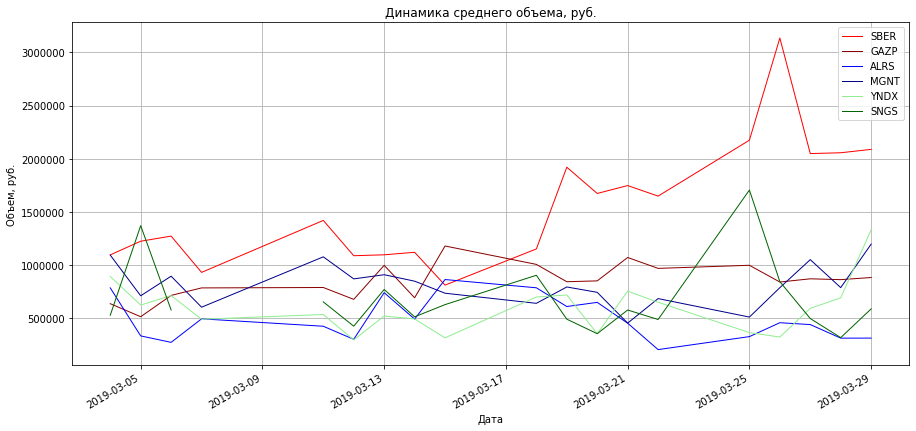

In [540]:
# график динамики среднего оборота по инструменту
dates = []
mean_sber = []
mean_gazp = []
mean_alrs = []
mean_mgnt = []
mean_yndx = []
mean_sngs = []

for a in range(len(orderlogs)):

    date = int(orderlogs[a][8:16])
    mean_sber.append(all_day_chain[(all_day_chain.TICKER == 'SBER') & (all_day_chain.DATE == date)]['VALUE'].mean())
    mean_gazp.append(all_day_chain[(all_day_chain.TICKER == 'GAZP') & (all_day_chain.DATE == date)]['VALUE'].mean())
    mean_alrs.append(all_day_chain[(all_day_chain.TICKER == 'ALRS') & (all_day_chain.DATE == date)]['VALUE'].mean())
    mean_mgnt.append(all_day_chain[(all_day_chain.TICKER == 'MGNT') & (all_day_chain.DATE == date)]['VALUE'].mean())
    mean_yndx.append(all_day_chain[(all_day_chain.TICKER == 'YNDX') & (all_day_chain.DATE == date)]['VALUE'].mean())
    mean_sngs.append(all_day_chain[(all_day_chain.TICKER == 'SNGS') & (all_day_chain.DATE == date)]['VALUE'].mean())
    dates.append(dt.datetime.strptime(str(date),'%Y%m%d'))
    
mean_by_instr = pd.DataFrame({'DATE':pd.Series(dates),
                              'SBER':pd.Series(mean_sber),
                              'GAZP':pd.Series(mean_gazp),
                              'ALRS':pd.Series(mean_alrs),
                              'MGNT':pd.Series(mean_mgnt),
                              'YNDX':pd.Series(mean_yndx),
                              'SNGS':pd.Series(mean_sngs)
                 })

# c - цвет точки
# s - размер точки
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика среднего объема, руб.')
plt.xlabel('Дата')
plt.ylabel('Объем, руб.')
ax.plot(mean_by_instr.DATE, mean_by_instr.SBER, linestyle = '-', linewidth = 1, color = 'red', label = 'SBER')
ax.plot(mean_by_instr.DATE, mean_by_instr.GAZP, linestyle = '-', linewidth = 1, color = 'darkred', label = 'GAZP')
ax.plot(mean_by_instr.DATE, mean_by_instr.ALRS, linestyle = '-', linewidth = 1, color = 'blue', label = 'ALRS')
ax.plot(mean_by_instr.DATE, mean_by_instr.MGNT, linestyle = '-', linewidth = 1, color = 'darkblue', label = 'MGNT')
ax.plot(mean_by_instr.DATE, mean_by_instr.YNDX, linestyle = '-', linewidth = 1, color = 'lightgreen', label = 'YNDX')
ax.plot(mean_by_instr.DATE, mean_by_instr.SNGS, linestyle = '-', linewidth = 1, color = 'darkgreen', label = 'SNGS')
ax.legend()
plt.gcf().autofmt_xdate()
fig.set_figwidth(15)
fig.set_figheight(7)
plt.show()
#fig.savefig('10 График среднего количества айсбергов внутри дня.png')

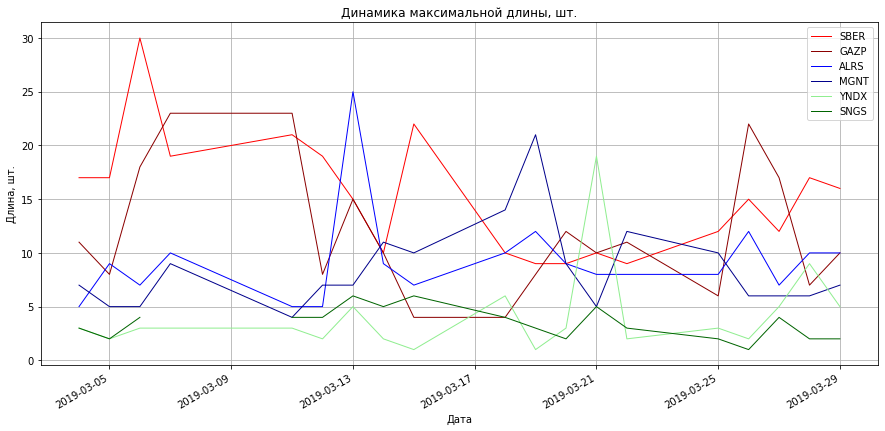

In [539]:
# график динамики максимальной длины по инструменту
dates = []
mean_sber = []
mean_gazp = []
mean_alrs = []
mean_mgnt = []
mean_yndx = []
mean_sngs = []

for a in range(len(orderlogs)):

    date = int(orderlogs[a][8:16])
    mean_sber.append(all_day_chain[(all_day_chain.TICKER == 'SBER') & (all_day_chain.DATE == date)]['LENGTH'].max())
    mean_gazp.append(all_day_chain[(all_day_chain.TICKER == 'GAZP') & (all_day_chain.DATE == date)]['LENGTH'].max())
    mean_alrs.append(all_day_chain[(all_day_chain.TICKER == 'ALRS') & (all_day_chain.DATE == date)]['LENGTH'].max())
    mean_mgnt.append(all_day_chain[(all_day_chain.TICKER == 'MGNT') & (all_day_chain.DATE == date)]['LENGTH'].max())
    mean_yndx.append(all_day_chain[(all_day_chain.TICKER == 'YNDX') & (all_day_chain.DATE == date)]['LENGTH'].max())
    mean_sngs.append(all_day_chain[(all_day_chain.TICKER == 'SNGS') & (all_day_chain.DATE == date)]['LENGTH'].max())
    dates.append(dt.datetime.strptime(str(date),'%Y%m%d'))
    
mean_by_instr = pd.DataFrame({'DATE':pd.Series(dates),
                              'SBER':pd.Series(mean_sber),
                              'GAZP':pd.Series(mean_gazp),
                              'ALRS':pd.Series(mean_alrs),
                              'MGNT':pd.Series(mean_mgnt),
                              'YNDX':pd.Series(mean_yndx),
                              'SNGS':pd.Series(mean_sngs)
                 })

# c - цвет точки
# s - размер точки
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика максимальной длины, шт.')
plt.xlabel('Дата')
plt.ylabel('Длина, шт.')
ax.plot(mean_by_instr.DATE, mean_by_instr.SBER, linestyle = '-', linewidth = 1, color = 'red', label = 'SBER')
ax.plot(mean_by_instr.DATE, mean_by_instr.GAZP, linestyle = '-', linewidth = 1, color = 'darkred', label = 'GAZP')
ax.plot(mean_by_instr.DATE, mean_by_instr.ALRS, linestyle = '-', linewidth = 1, color = 'blue', label = 'ALRS')
ax.plot(mean_by_instr.DATE, mean_by_instr.MGNT, linestyle = '-', linewidth = 1, color = 'darkblue', label = 'MGNT')
ax.plot(mean_by_instr.DATE, mean_by_instr.YNDX, linestyle = '-', linewidth = 1, color = 'lightgreen', label = 'YNDX')
ax.plot(mean_by_instr.DATE, mean_by_instr.SNGS, linestyle = '-', linewidth = 1, color = 'darkgreen', label = 'SNGS')
ax.legend()
plt.gcf().autofmt_xdate()
fig.set_figwidth(15)
fig.set_figheight(7)
plt.show()
#fig.savefig('10 График среднего количества айсбергов внутри дня.png')

/Users/ekaterina/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


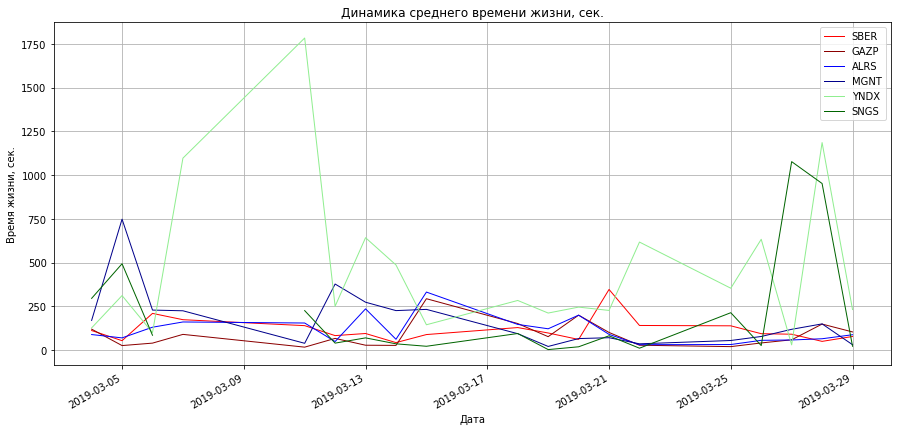

In [538]:
# график динамики максимальной длины по инструменту
dates = []
mean_sber = []
mean_gazp = []
mean_alrs = []
mean_mgnt = []
mean_yndx = []
mean_sngs = []

for a in range(len(orderlogs)):

    date = int(orderlogs[a][8:16])
    mean_sber.append(all_day_chain[(all_day_chain.TICKER == 'SBER') & (all_day_chain.DATE == date)]['LIFE'].mean().seconds)
    mean_gazp.append(all_day_chain[(all_day_chain.TICKER == 'GAZP') & (all_day_chain.DATE == date)]['LIFE'].mean().seconds)
    mean_alrs.append(all_day_chain[(all_day_chain.TICKER == 'ALRS') & (all_day_chain.DATE == date)]['LIFE'].mean().seconds)
    mean_mgnt.append(all_day_chain[(all_day_chain.TICKER == 'MGNT') & (all_day_chain.DATE == date)]['LIFE'].mean().seconds)
    mean_yndx.append(all_day_chain[(all_day_chain.TICKER == 'YNDX') & (all_day_chain.DATE == date)]['LIFE'].mean().seconds)
    mean_sngs.append(all_day_chain[(all_day_chain.TICKER == 'SNGS') & (all_day_chain.DATE == date)]['LIFE'].mean().seconds)
    dates.append(dt.datetime.strptime(str(date),'%Y%m%d'))
    
mean_by_instr = pd.DataFrame({'DATE':pd.Series(dates),
                              'SBER':pd.Series(mean_sber),
                              'GAZP':pd.Series(mean_gazp),
                              'ALRS':pd.Series(mean_alrs),
                              'MGNT':pd.Series(mean_mgnt),
                              'YNDX':pd.Series(mean_yndx),
                              'SNGS':pd.Series(mean_sngs)
                 })

# c - цвет точки
# s - размер точки
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика среднего времени жизни, сек.')
plt.xlabel('Дата')
plt.ylabel('Время жизни, сек.')
ax.plot(mean_by_instr.DATE, mean_by_instr.SBER, linestyle = '-', linewidth = 1, color = 'red', label = 'SBER')
ax.plot(mean_by_instr.DATE, mean_by_instr.GAZP, linestyle = '-', linewidth = 1, color = 'darkred', label = 'GAZP')
ax.plot(mean_by_instr.DATE, mean_by_instr.ALRS, linestyle = '-', linewidth = 1, color = 'blue', label = 'ALRS')
ax.plot(mean_by_instr.DATE, mean_by_instr.MGNT, linestyle = '-', linewidth = 1, color = 'darkblue', label = 'MGNT')
ax.plot(mean_by_instr.DATE, mean_by_instr.YNDX, linestyle = '-', linewidth = 1, color = 'lightgreen', label = 'YNDX')
ax.plot(mean_by_instr.DATE, mean_by_instr.SNGS, linestyle = '-', linewidth = 1, color = 'darkgreen', label = 'SNGS')
ax.legend()
plt.gcf().autofmt_xdate()
fig.set_figwidth(15)
fig.set_figheight(7)
plt.show()
#fig.savefig('10 График среднего количества айсбергов внутри дня.png')

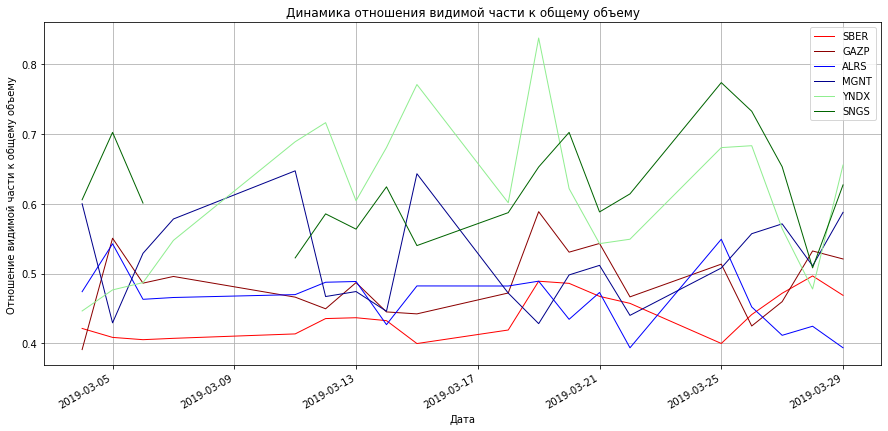

In [598]:
# график динамики среднего отношения видимой и скрытой части по инструменту
dates = []
mean_sber = []
mean_gazp = []
mean_alrs = []
mean_mgnt = []
mean_yndx = []
mean_sngs = []

for a in range(len(orderlogs)):

    date = int(orderlogs[a][8:16])
    mean_sber.append(all_day_chain[(all_day_chain.TICKER == 'SBER') & (all_day_chain.DATE == date)]['HID/ALL'].mean())
    mean_gazp.append(all_day_chain[(all_day_chain.TICKER == 'GAZP') & (all_day_chain.DATE == date)]['HID/ALL'].mean())
    mean_alrs.append(all_day_chain[(all_day_chain.TICKER == 'ALRS') & (all_day_chain.DATE == date)]['HID/ALL'].mean())
    mean_mgnt.append(all_day_chain[(all_day_chain.TICKER == 'MGNT') & (all_day_chain.DATE == date)]['HID/ALL'].mean())
    mean_yndx.append(all_day_chain[(all_day_chain.TICKER == 'YNDX') & (all_day_chain.DATE == date)]['HID/ALL'].mean())
    mean_sngs.append(all_day_chain[(all_day_chain.TICKER == 'SNGS') & (all_day_chain.DATE == date)]['HID/ALL'].mean())
    dates.append(dt.datetime.strptime(str(date),'%Y%m%d'))
    
mean_by_instr = pd.DataFrame({'DATE':pd.Series(dates),
                              'SBER':pd.Series(mean_sber),
                              'GAZP':pd.Series(mean_gazp),
                              'ALRS':pd.Series(mean_alrs),
                              'MGNT':pd.Series(mean_mgnt),
                              'YNDX':pd.Series(mean_yndx),
                              'SNGS':pd.Series(mean_sngs)
                 })

# c - цвет точки
# s - размер точки
fig, ax = plt.subplots()
plt.grid()
plt.title('Динамика отношения видимой части к общему объему')
plt.xlabel('Дата')
plt.ylabel('Отношение видимой части к общему объему')
ax.plot(mean_by_instr.DATE, mean_by_instr.SBER, linestyle = '-', linewidth = 1, color = 'red', label = 'SBER')
ax.plot(mean_by_instr.DATE, mean_by_instr.GAZP, linestyle = '-', linewidth = 1, color = 'darkred', label = 'GAZP')
ax.plot(mean_by_instr.DATE, mean_by_instr.ALRS, linestyle = '-', linewidth = 1, color = 'blue', label = 'ALRS')
ax.plot(mean_by_instr.DATE, mean_by_instr.MGNT, linestyle = '-', linewidth = 1, color = 'darkblue', label = 'MGNT')
ax.plot(mean_by_instr.DATE, mean_by_instr.YNDX, linestyle = '-', linewidth = 1, color = 'lightgreen', label = 'YNDX')
ax.plot(mean_by_instr.DATE, mean_by_instr.SNGS, linestyle = '-', linewidth = 1, color = 'darkgreen', label = 'SNGS')
ax.legend()
plt.gcf().autofmt_xdate()
fig.set_figwidth(15)
fig.set_figheight(7)
plt.show()
#fig.savefig('10 График среднего количества айсбергов внутри дня.png')